# Adversarial Attack Analysis on VAE

This notebook loads a pre-trained VAE model and performs comprehensive adversarial attack analysis using functions from the `attack_analysis` module.

## Analysis Components:
1. **Visual Attack Analysis**: 6-row visualization showing original, adversarial, and difference images
2. **Attack Method Comparison**: Effectiveness comparison across FGSM, PGD, and Custom attacks
3. **Efficiency Scaling**: How attack success scales with epsilon parameter
4. **Latent Space Analysis**: How attacks affect digit clustering in latent space

## Attack Methods:
- **FGSM** (Fast Gradient Sign Method)
- **PGD** (Projected Gradient Descent)
- **Custom Iterative Attack**
- **Latent Space Attack**

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Import necessary libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import glob
from datetime import datetime

# Import VAE and attack classes
from adversarial_vae_attack import (
    VAE, 
    AdversarialAttacks,
    get_mnist_loaders, 
    get_device,
    vae_loss,
    create_efficiency_heatmap,
    plot_efficiency_scaling,
    save_efficiency_analysis
)

# Import attack analysis functions
from attack_analysis import (
    visualize_attack_analysis,
    custom_vae_attack,
    compare_attack_effectiveness,
    analyze_attack_success_rates,
    comprehensive_attack_efficiency,
    plot_attack_efficiency_scaling,
    plot_simple_efficiency_summary,
    sample_digits_by_class,
    analyze_latent_clustering_under_attack,
    plot_latent_clustering_comparison,
    compare_latent_disruption_across_attacks,
    save_analysis_results
)

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All imports successful!
PyTorch version: 2.5.1
CUDA available: False


In [3]:
# Setup configuration
device = get_device()

CONFIG = {
    'latent_dim': 2,
    'batch_size_test': 64,
    'data_dir': './data',
    'n_attack_samples': 8,  # Number of samples for visualization
    'attack_epsilons': [0.05, 0.1, 0.15, 0.2],  # Perturbation strengths
    'efficiency_samples': 1000,  # Samples for efficiency analysis
    'clustering_samples': 12    # Samples per digit for clustering analysis
}

print("📋 Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Using device: mps
📋 Configuration:
  latent_dim: 2
  batch_size_test: 64
  data_dir: ./data
  n_attack_samples: 8
  attack_epsilons: [0.05, 0.1, 0.15, 0.2]
  efficiency_samples: 1000
  clustering_samples: 12


In [13]:
# Load the most recent trained model
def load_latest_model():
    """Load the most recently saved VAE model and its metadata"""
    model_files = glob.glob("vae_model_*.pth")
    
    if not model_files:
        raise FileNotFoundError("No trained VAE models found. Please run vae_trainer1.ipynb first.")
    
    model_files.sort()
    latest_model_file = model_files[-1]
    timestamp = latest_model_file.split('_')[-1].split('.')[0]
    
    # Load metadata
    metadata_file = f"vae_metadata_{timestamp}.json"
    metadata = None
    if os.path.exists(metadata_file):
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
    
    # Initialize and load model
    model = VAE(latent_dim=CONFIG['latent_dim'])
    model.load_state_dict(torch.load(latest_model_file, map_location=device))
    model.to(device)
    model.eval()
    
    print(f"📁 Loaded model: {latest_model_file}")
    if metadata:
        print(f"🕒 Training timestamp: {metadata['timestamp']}")
        print(f"📊 Final training loss: {metadata['training_info']['final_loss']:.6f}")
        print(f"🎯 Loss reduction: {metadata['training_info']['loss_reduction_percent']:.2f}%")
    
    return model, metadata, timestamp

# Load model and data
model, metadata, model_timestamp = load_latest_model()

print("\n📊 Loading MNIST test dataset...")
_, test_loader = get_mnist_loaders(
    batch_size_train=128,
    batch_size_test=CONFIG['batch_size_test'],
    data_dir=CONFIG['data_dir']
)

# Get sample data with flexible selection options
def get_attack_samples(test_loader, device, n_samples, target_digit=None, random_selection=True):
    """
    Get samples for attack analysis with flexible selection options.
    
    Args:
        test_loader: DataLoader for test data
        device: Device to move tensors to
        n_samples: Number of samples to select
        target_digit: If specified, only select samples of this digit class (0-9)
        random_selection: If True, randomly select samples; if False, take first n_samples
    
    Returns:
        tuple: (sample_images, sample_labels)
    """
    all_images = []
    all_labels = []
    
    # Collect data from test loader
    with torch.no_grad():
        for batch_images, batch_labels in test_loader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            
            if target_digit is not None:
                # Filter for specific digit
                mask = batch_labels == target_digit
                if mask.any():
                    all_images.append(batch_images[mask])
                    all_labels.append(batch_labels[mask])
            else:
                # Keep all samples
                all_images.append(batch_images)
                all_labels.append(batch_labels)
            
            # Stop when we have enough samples
            total_collected = sum(len(labels) for labels in all_labels)
            if total_collected >= n_samples * 2:  # Collect extra for random selection
                break
    
    # Concatenate all collected data
    if all_images:
        all_images = torch.cat(all_images, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
    else:
        raise ValueError(f"No samples found for digit {target_digit}")
    
    # Select samples
    if random_selection and len(all_images) > n_samples:
        # Random selection
        indices = torch.randperm(len(all_images))[:n_samples]
        sample_images = all_images[indices]
        sample_labels = all_labels[indices]
    else:
        # Sequential selection
        sample_images = all_images[:n_samples]
        sample_labels = all_labels[:n_samples]
    
    return sample_images, sample_labels


# Sample selection options - modify these as needed:
SAMPLE_OPTIONS = {
    'random_selection': True,           # Set to False for sequential selection
    'target_digit': None,              # Set to 0-9 to filter by digit, None for all digits
    'n_samples': CONFIG['n_attack_samples']
}

print("🎯 Sample Selection Options:")
print(f"   Random selection: {SAMPLE_OPTIONS['random_selection']}")
print(f"   Target digit: {SAMPLE_OPTIONS['target_digit'] if SAMPLE_OPTIONS['target_digit'] is not None else 'All digits'}")
print(f"   Number of samples: {SAMPLE_OPTIONS['n_samples']}")

# Get samples using the flexible function
sample_images, sample_labels = get_attack_samples(
    test_loader, 
    device, 
    n_samples=SAMPLE_OPTIONS['n_samples'],
    target_digit=SAMPLE_OPTIONS['target_digit'],
    random_selection=SAMPLE_OPTIONS['random_selection']
)

print(f"\n✅ Dataset loaded: {len(test_loader.dataset)} test samples")
print(f"📝 Selected sample labels: {sample_labels.cpu().numpy()}")
if SAMPLE_OPTIONS['target_digit'] is not None:
    print(f"🎯 All samples are digit {SAMPLE_OPTIONS['target_digit']}")
if SAMPLE_OPTIONS['random_selection']:
    print("🎲 Samples were randomly selected")
else:
    print("📋 Samples were sequentially selected")

📁 Loaded model: vae_model_20250715_104503.pth

📊 Loading MNIST test dataset...
🎯 Sample Selection Options:
   Random selection: True
   Target digit: All digits
   Number of samples: 8

✅ Dataset loaded: 10000 test samples
📝 Selected sample labels: [1 2 3 4 1 1 6 9]
🎲 Samples were randomly selected


/var/folders/ll/7kn2qpx13h3d33v8br6bk2gw0000gp/T/ipykernel_26113/510534565.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(latest_model

## 🔥 FGSM Attack Analysis

Fast Gradient Sign Method - simple but effective single-step attack.

## 🎯 Sample Selection Examples

You can modify the `SAMPLE_OPTIONS` in the previous cell to change how samples are selected:

### **Option 1: Random samples from all digits**
```python
SAMPLE_OPTIONS = {
    'random_selection': True,
    'target_digit': None,
    'n_samples': 8
}
```

### **Option 2: Random samples of digit 7 only**
```python
SAMPLE_OPTIONS = {
    'random_selection': True,
    'target_digit': 7,
    'n_samples': 8
}
```

### **Option 3: First 8 samples sequentially**
```python
SAMPLE_OPTIONS = {
    'random_selection': False,
    'target_digit': None,
    'n_samples': 8
}
```

### **Option 4: First 8 samples of digit 3**
```python
SAMPLE_OPTIONS = {
    'random_selection': False,
    'target_digit': 3,
    'n_samples': 8
}
```

**Note:** After changing `SAMPLE_OPTIONS`, re-run the previous cell to update your sample selection!

🔥 Performing FGSM Attack Analysis...

🎯 Testing FGSM with epsilon = 0.05


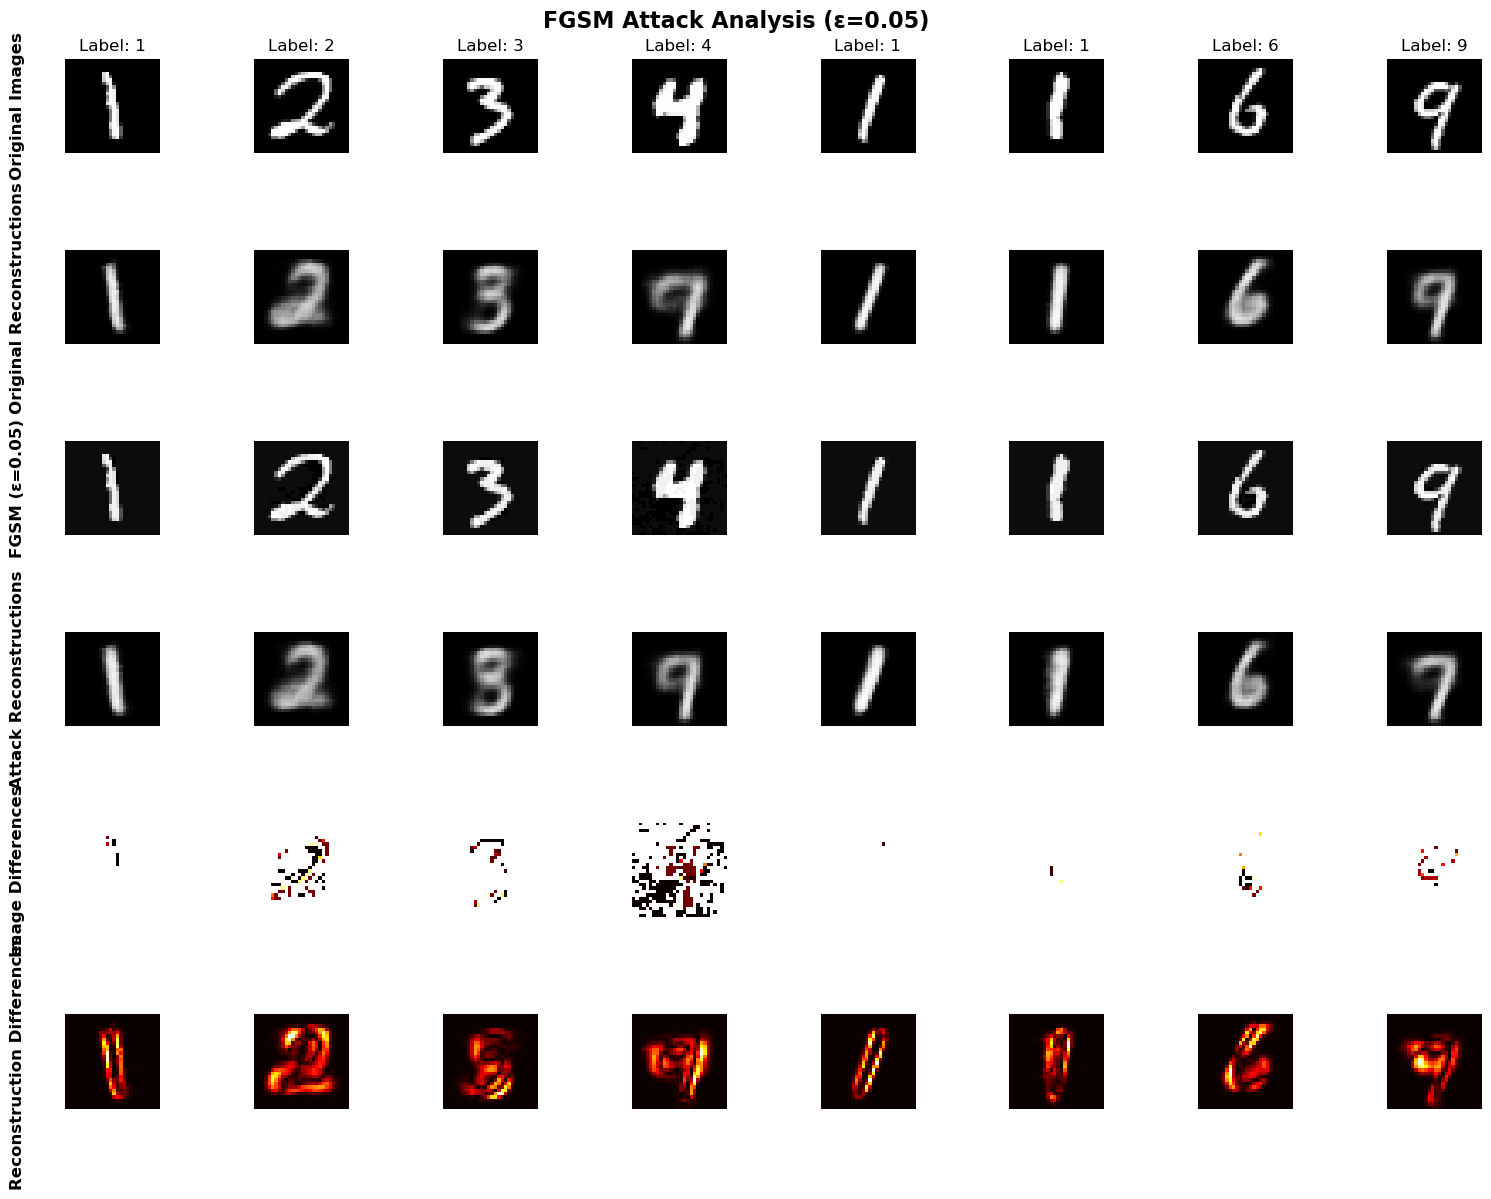

📊 FGSM Attack Metrics (ε=0.05):
   Image MSE: 0.002342
   Reconstruction MSE: 0.005117
   Max image perturbation: 0.050000
   Max reconstruction change: 0.581507
   Attack success: ✅
--------------------------------------------------

🎯 Testing FGSM with epsilon = 0.1


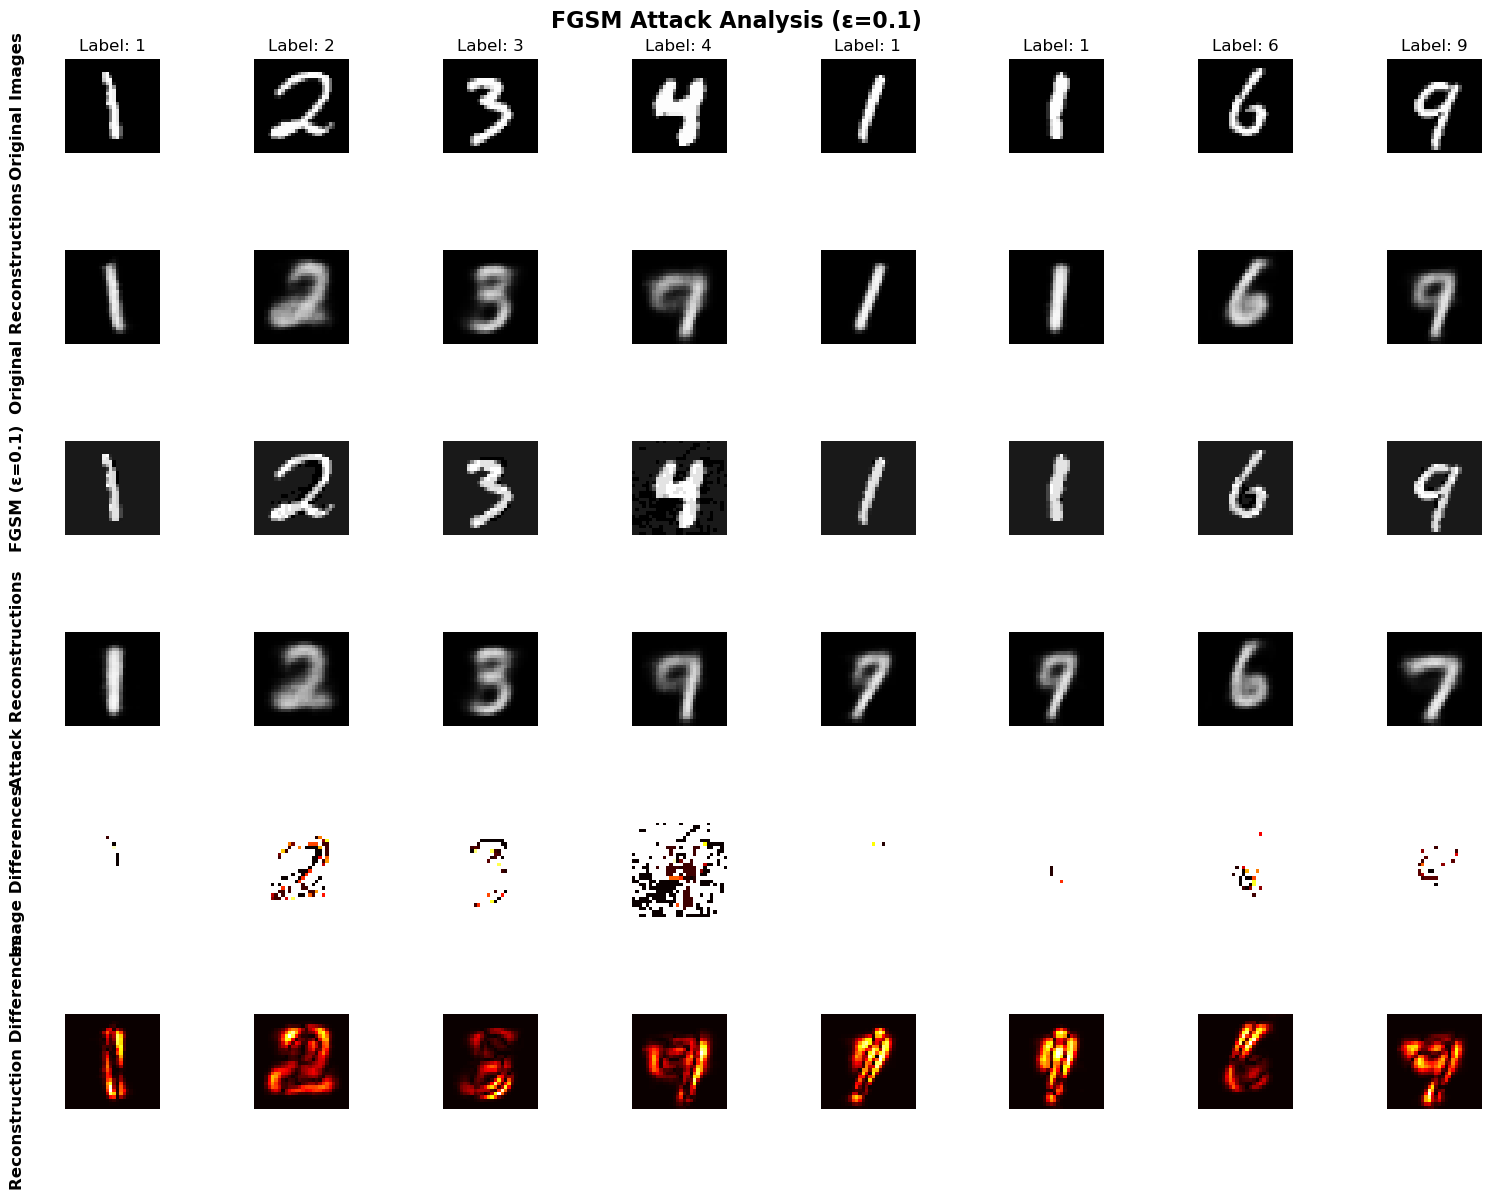

📊 FGSM Attack Metrics (ε=0.1):
   Image MSE: 0.009340
   Reconstruction MSE: 0.019025
   Max image perturbation: 0.100000
   Max reconstruction change: 0.873285
   Attack success: ✅
--------------------------------------------------

🎯 Testing FGSM with epsilon = 0.15


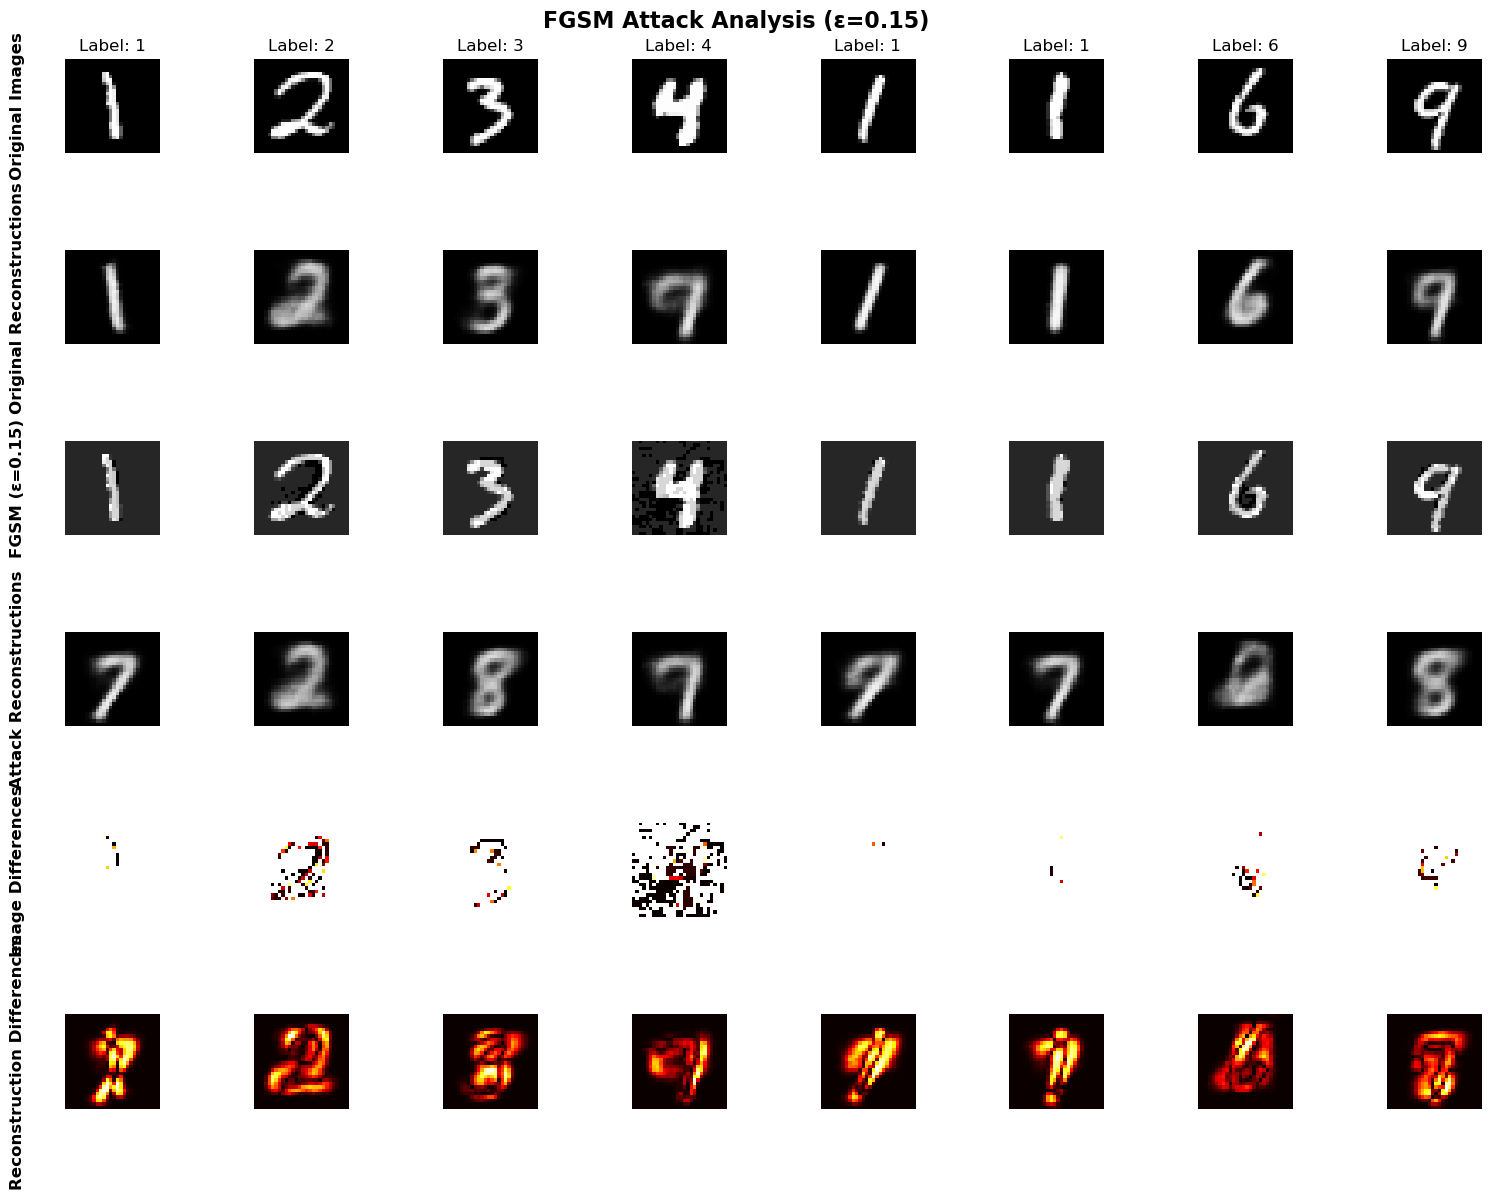

📊 FGSM Attack Metrics (ε=0.15):
   Image MSE: 0.020920
   Reconstruction MSE: 0.035336
   Max image perturbation: 0.150000
   Max reconstruction change: 0.935945
   Attack success: ✅
--------------------------------------------------

🎯 Testing FGSM with epsilon = 0.2


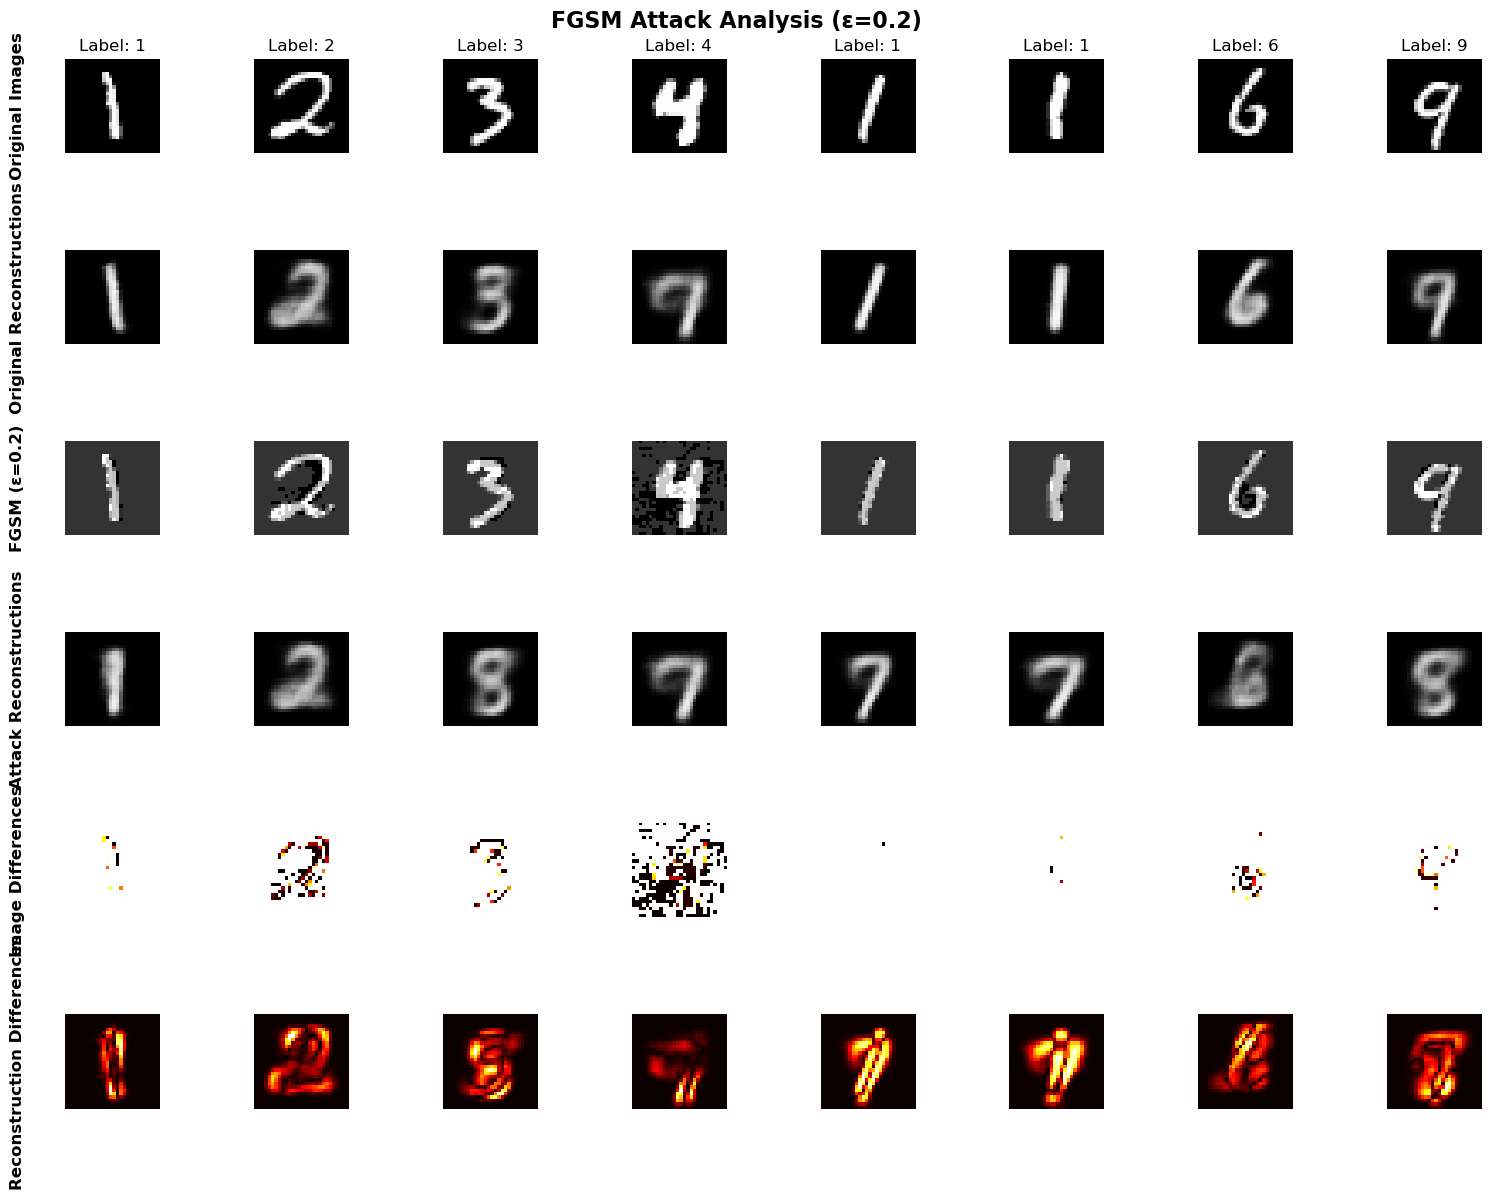

📊 FGSM Attack Metrics (ε=0.2):
   Image MSE: 0.037061
   Reconstruction MSE: 0.028212
   Max image perturbation: 0.200000
   Max reconstruction change: 0.916312
   Attack success: ✅
--------------------------------------------------


In [14]:
# FGSM Attack Analysis
print("🔥 Performing FGSM Attack Analysis...")

attacks = AdversarialAttacks()

# Get original reconstructions
with torch.no_grad():
    original_recons, _, _ = model(sample_images)

# Test different epsilon values
for epsilon in CONFIG['attack_epsilons']:
    print(f"\n🎯 Testing FGSM with epsilon = {epsilon}")
    
    # Perform FGSM attack
    fgsm_images = attacks.fgsm_attack(model, sample_images, sample_images, epsilon)
    
    # Get adversarial reconstructions
    with torch.no_grad():
        fgsm_recons, _, _ = model(fgsm_images)
    
    # Visualize attack analysis
    visualize_attack_analysis(
        sample_images, original_recons, fgsm_images, fgsm_recons,
        "FGSM", epsilon, sample_labels
    )

## 🔥 PGD Attack Analysis

Projected Gradient Descent - iterative attack with multiple refinement steps.

🔥 Performing PGD Attack Analysis...

🎯 Testing PGD with epsilon = 0.05


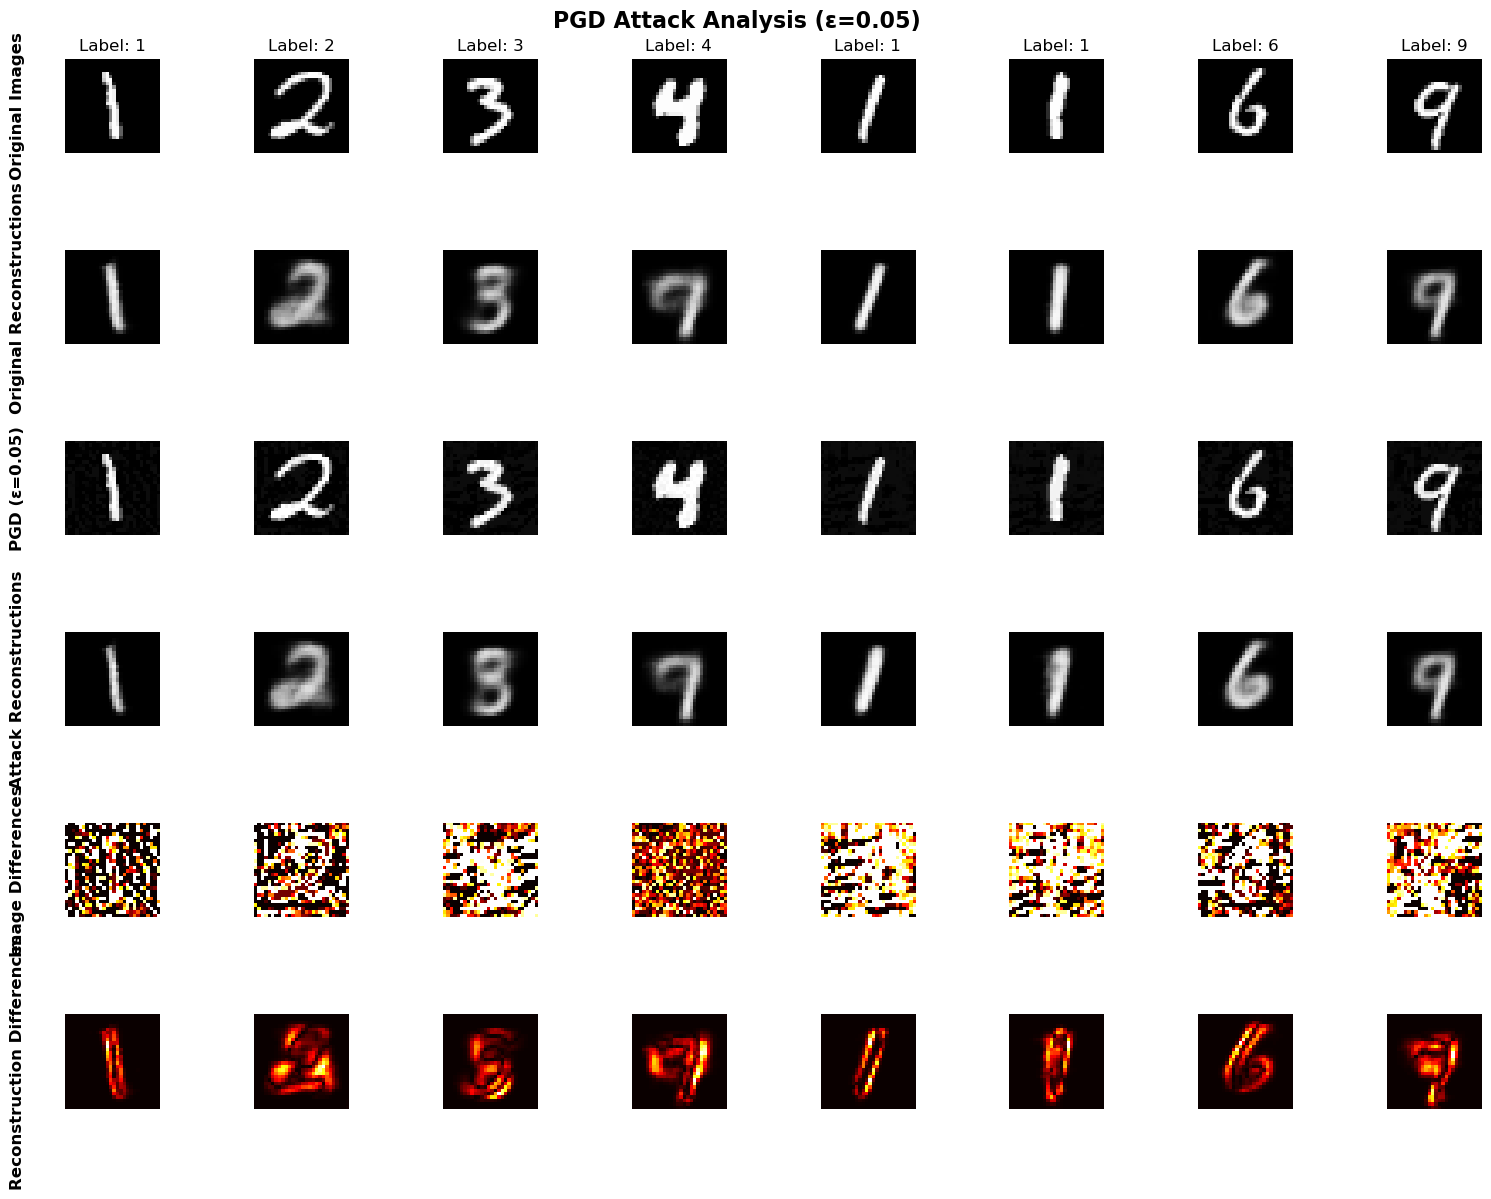

📊 PGD Attack Metrics (ε=0.05):
   Image MSE: 0.001087
   Reconstruction MSE: 0.004351
   Max image perturbation: 0.050000
   Max reconstruction change: 0.634167
   Attack success: ✅
--------------------------------------------------

🎯 Testing PGD with epsilon = 0.1


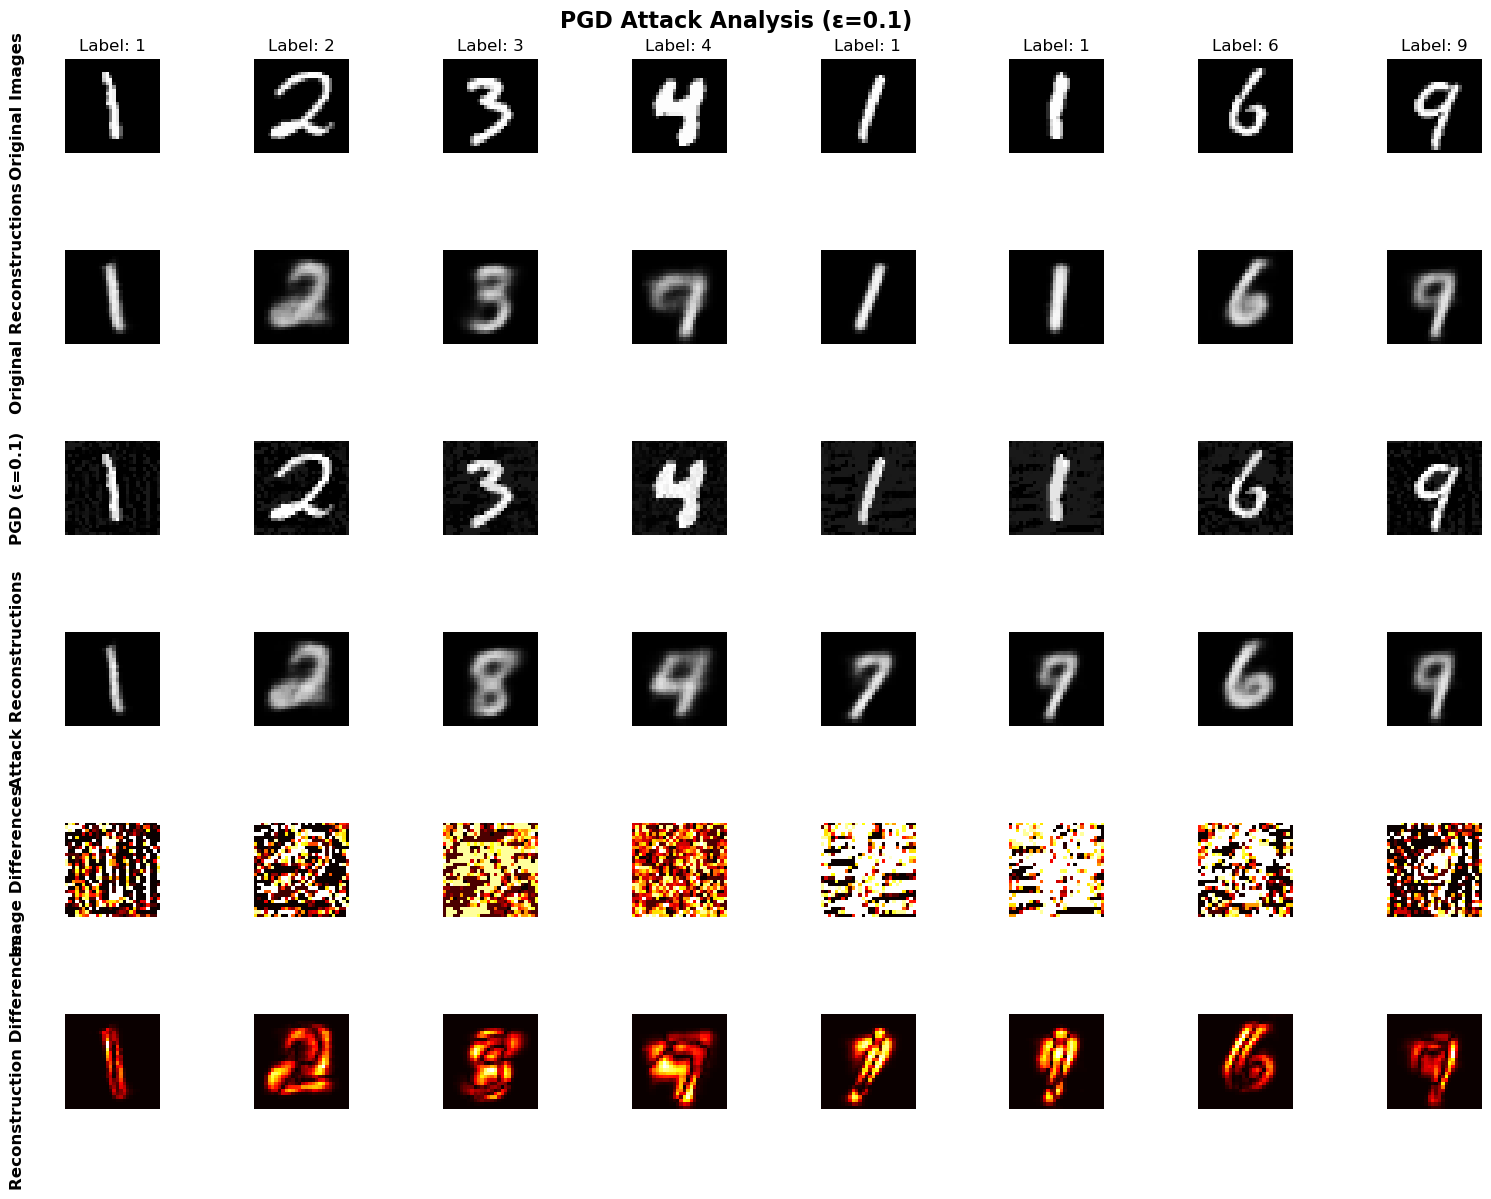

📊 PGD Attack Metrics (ε=0.1):
   Image MSE: 0.004344
   Reconstruction MSE: 0.020638
   Max image perturbation: 0.100000
   Max reconstruction change: 0.892446
   Attack success: ✅
--------------------------------------------------

🎯 Testing PGD with epsilon = 0.15


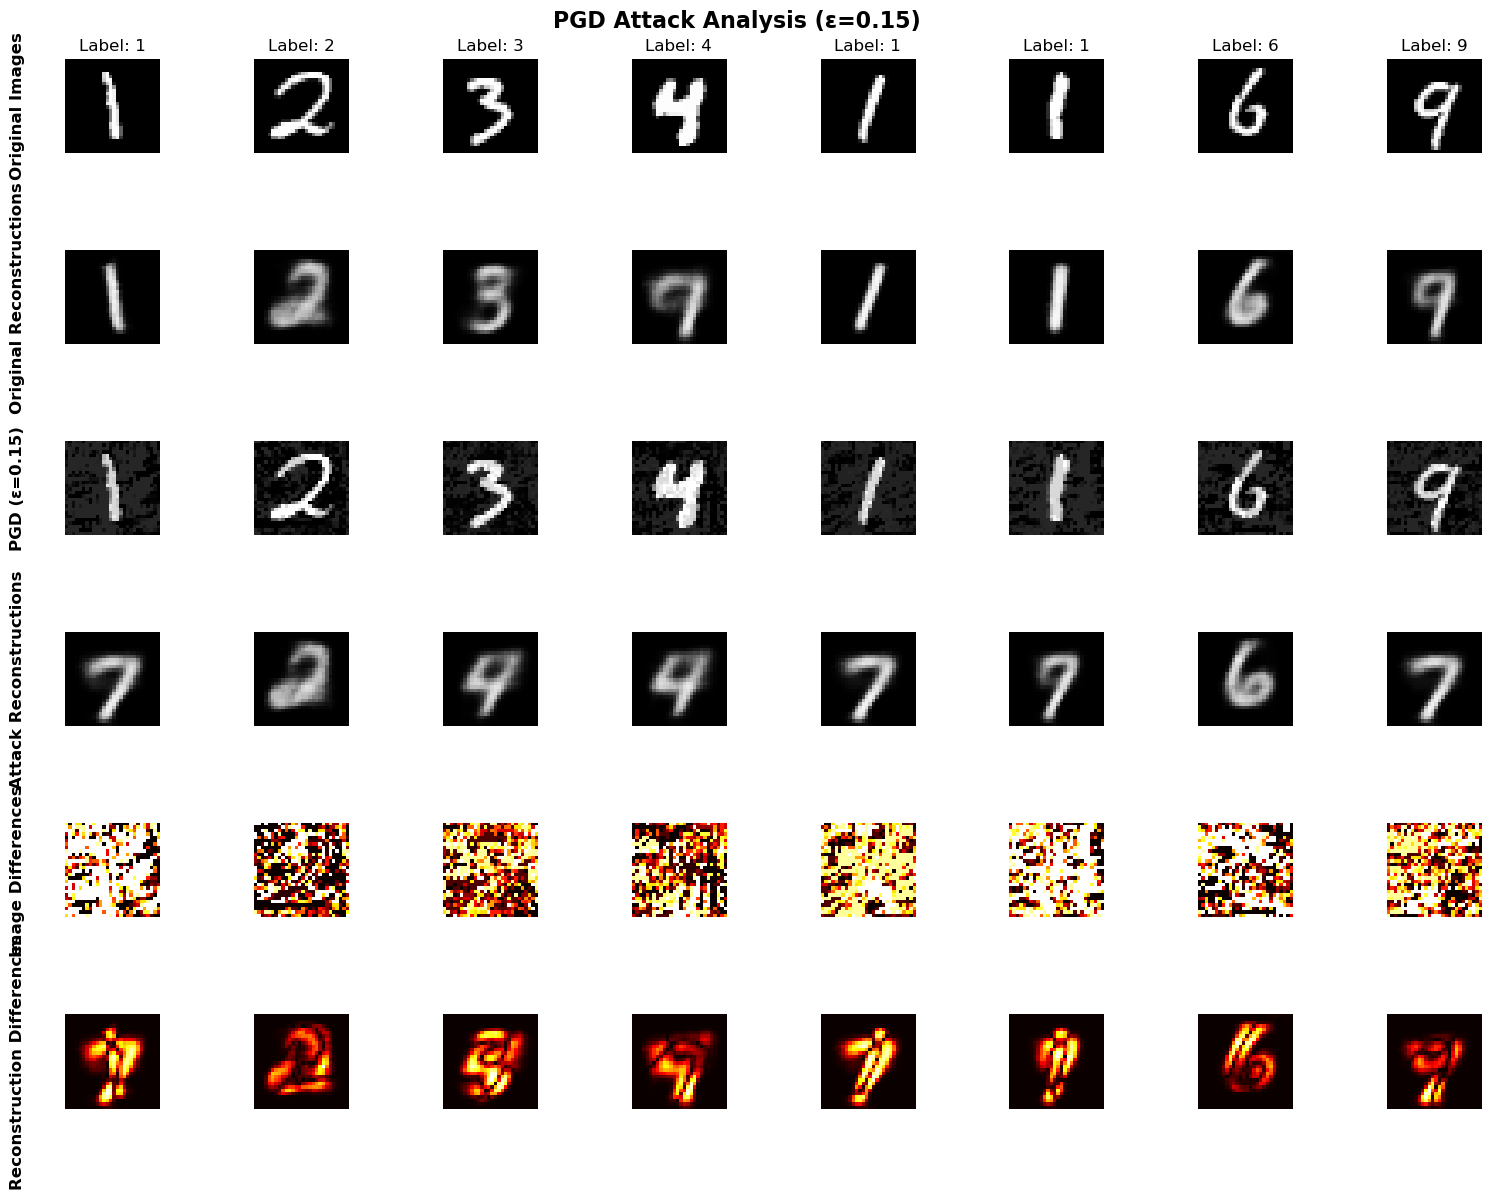

📊 PGD Attack Metrics (ε=0.15):
   Image MSE: 0.010514
   Reconstruction MSE: 0.045372
   Max image perturbation: 0.150000
   Max reconstruction change: 0.942100
   Attack success: ✅
--------------------------------------------------

🎯 Testing PGD with epsilon = 0.2


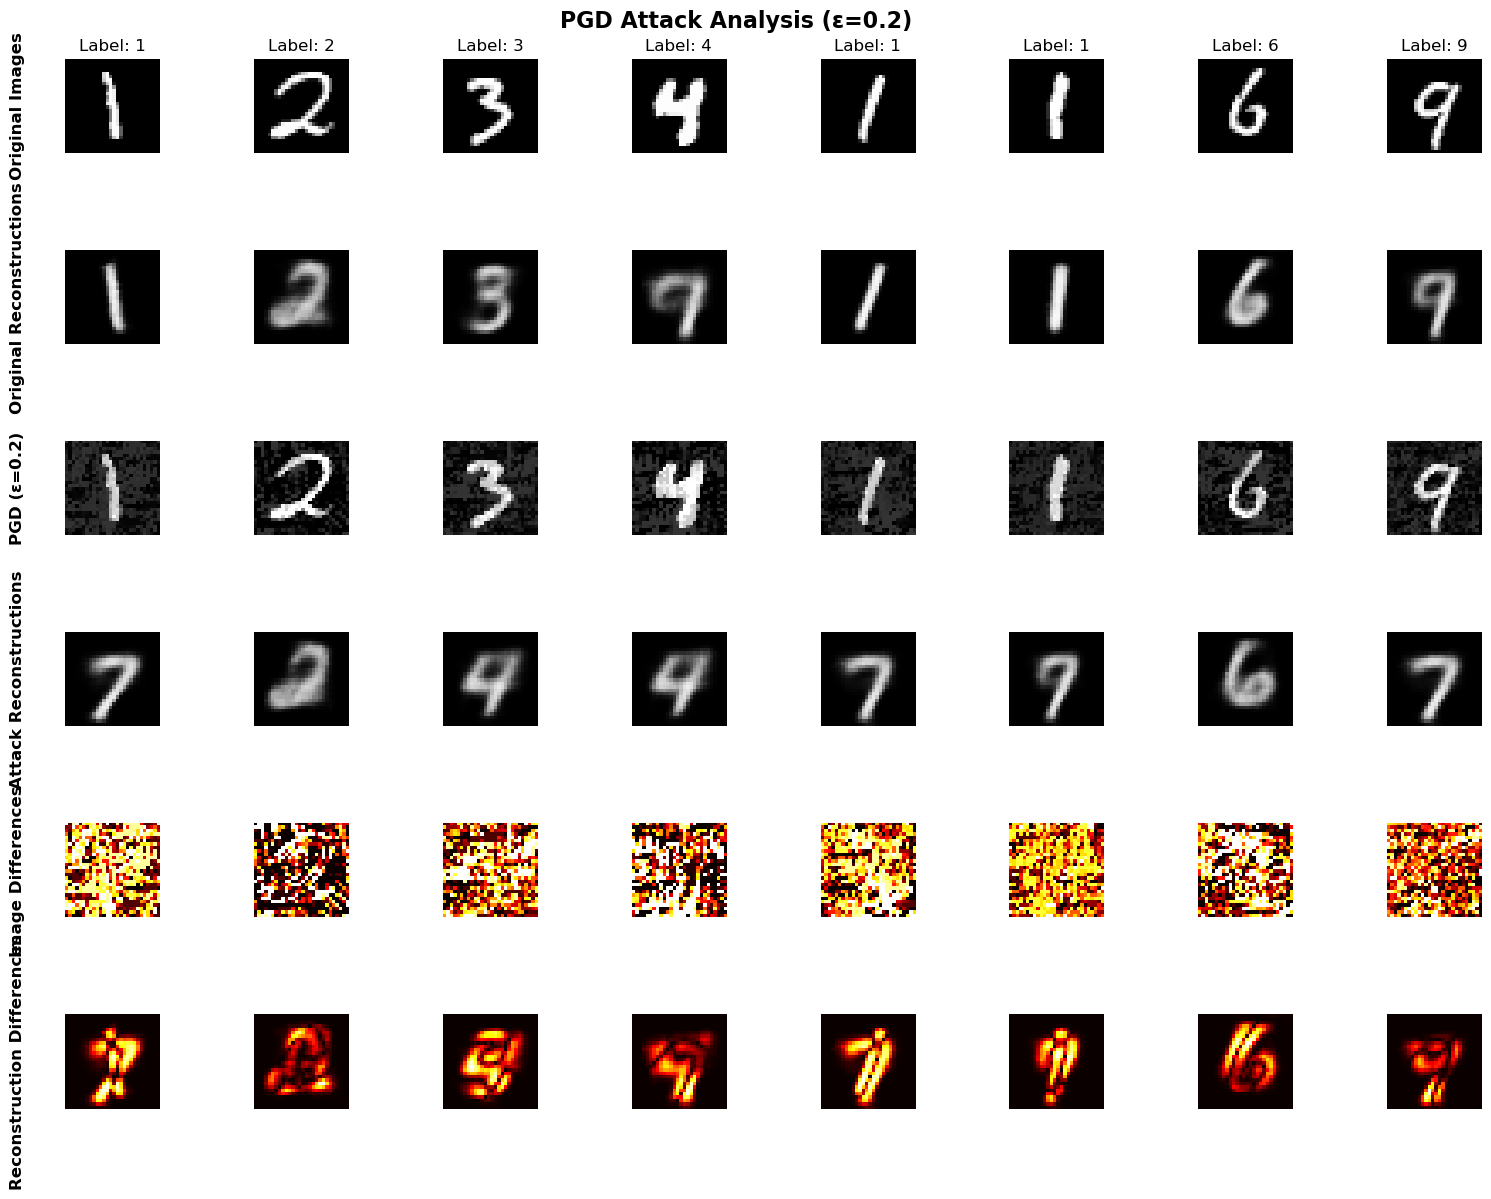

📊 PGD Attack Metrics (ε=0.2):
   Image MSE: 0.014993
   Reconstruction MSE: 0.046469
   Max image perturbation: 0.200000
   Max reconstruction change: 0.943647
   Attack success: ✅
--------------------------------------------------


In [15]:
# PGD Attack Analysis
print("🔥 Performing PGD Attack Analysis...")

for epsilon in CONFIG['attack_epsilons']:
    print(f"\n🎯 Testing PGD with epsilon = {epsilon}")
    
    # Perform PGD attack
    pgd_images = attacks.pgd_attack(
        model, sample_images, sample_images, 
        epsilon=epsilon, alpha=epsilon/10, num_iter=20
    )
    
    # Get adversarial reconstructions
    with torch.no_grad():
        pgd_recons, _, _ = model(pgd_images)
    
    # Visualize attack analysis
    visualize_attack_analysis(
        sample_images, original_recons, pgd_images, pgd_recons,
        "PGD", epsilon, sample_labels
    )

## 🔥 Latent Space Attack Analysis

Attack that directly manipulates latent space representations.

🔥 Performing Latent Space Attack Analysis...

🎯 Testing Latent Attack with epsilon = 0.5


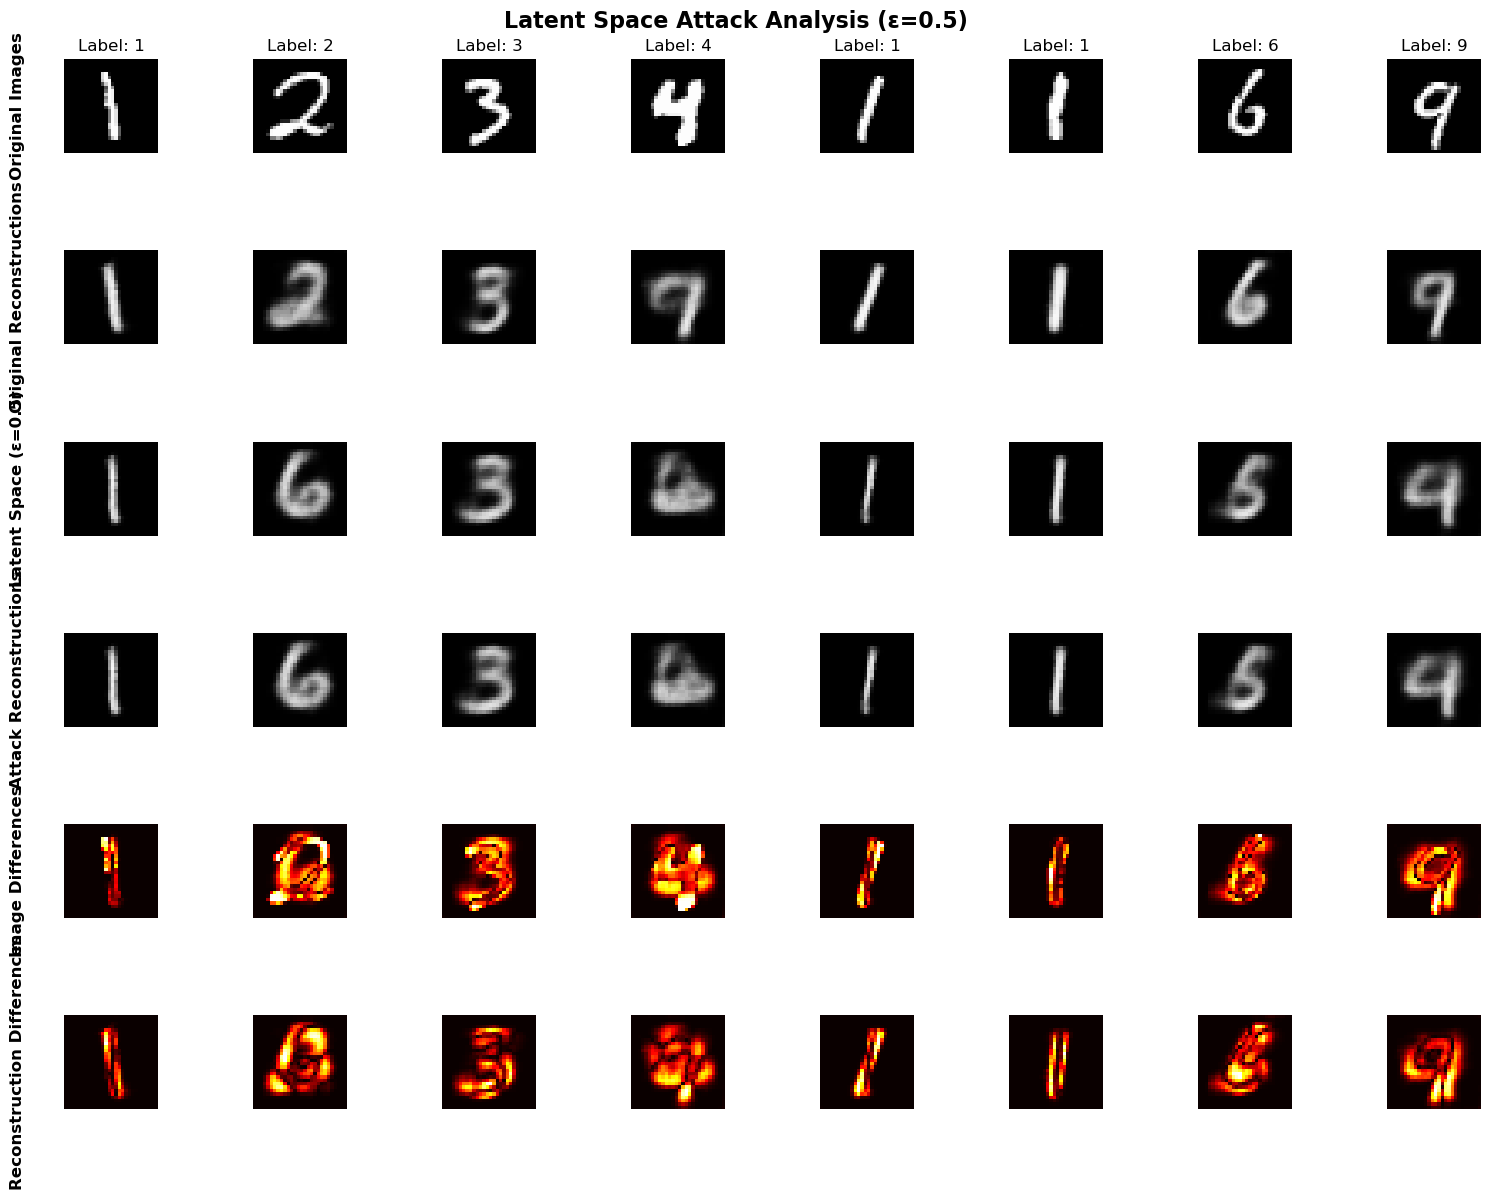

📊 Latent Space Attack Metrics (ε=0.5):
   Image MSE: 0.054762
   Reconstruction MSE: 0.028160
   Max image perturbation: 0.996077
   Max reconstruction change: 0.927876
   Attack success: ✅
--------------------------------------------------

🎯 Testing Latent Attack with epsilon = 1.0


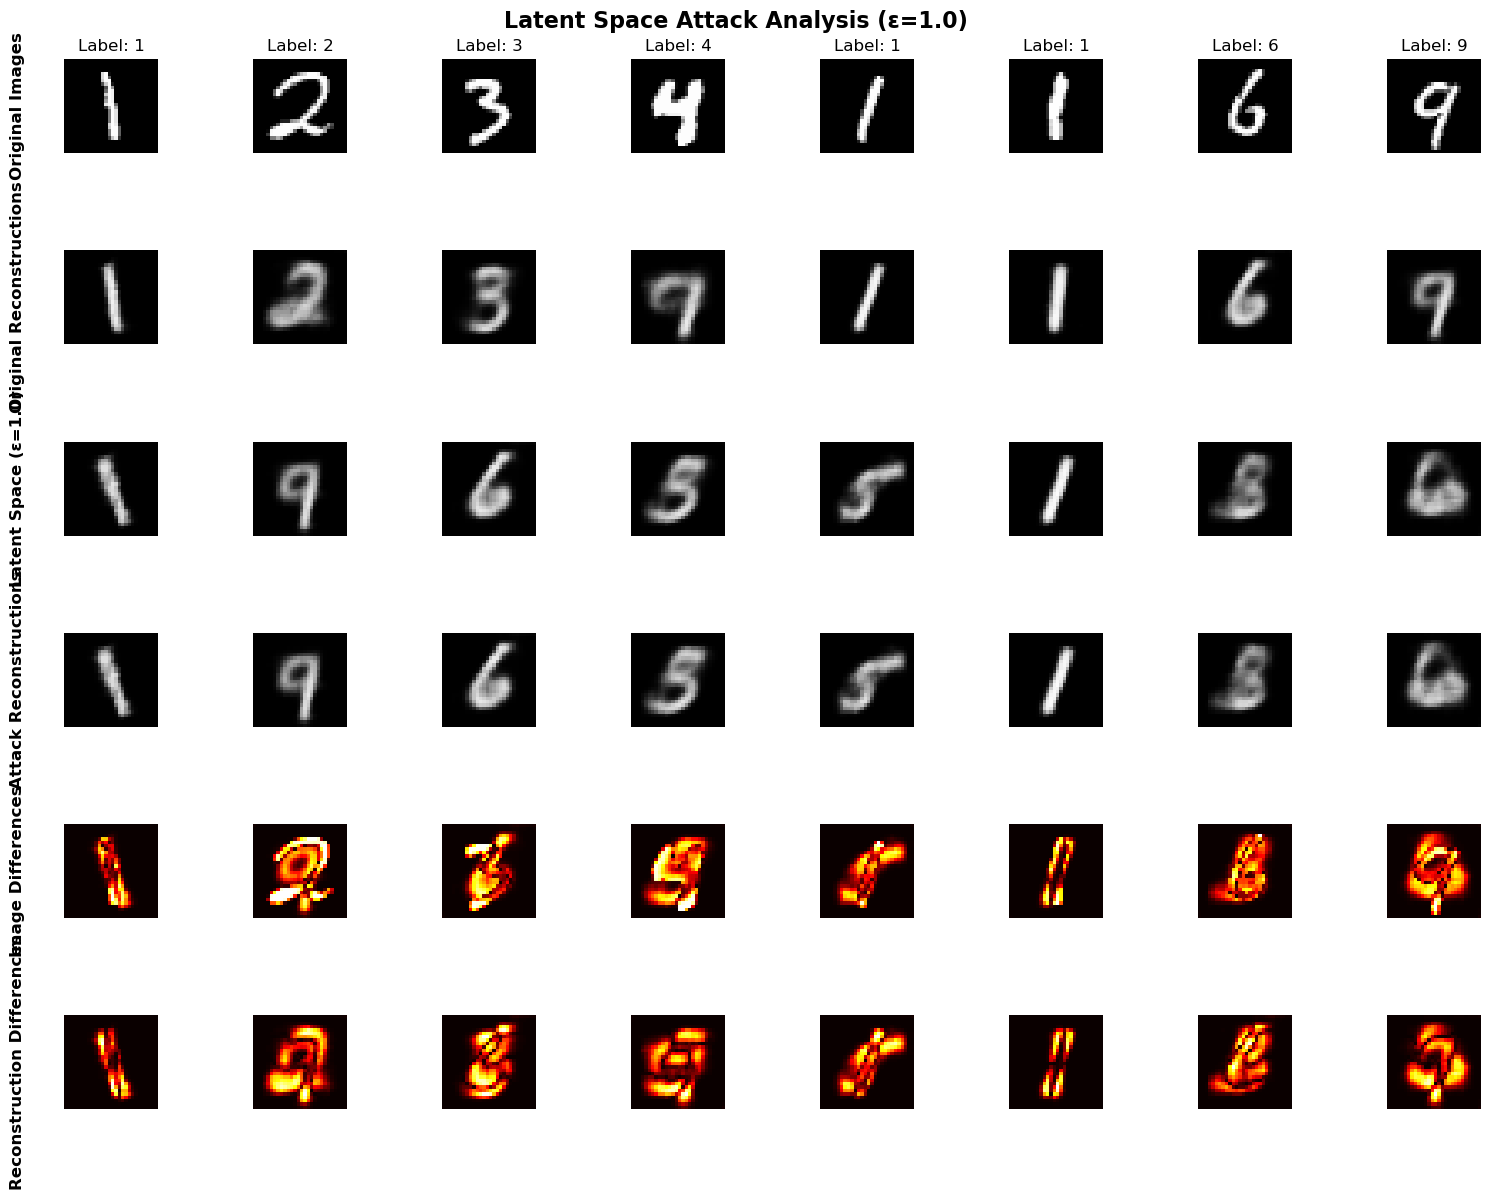

📊 Latent Space Attack Metrics (ε=1.0):
   Image MSE: 0.072891
   Reconstruction MSE: 0.043472
   Max image perturbation: 0.999979
   Max reconstruction change: 0.899155
   Attack success: ✅
--------------------------------------------------

🎯 Testing Latent Attack with epsilon = 2.0


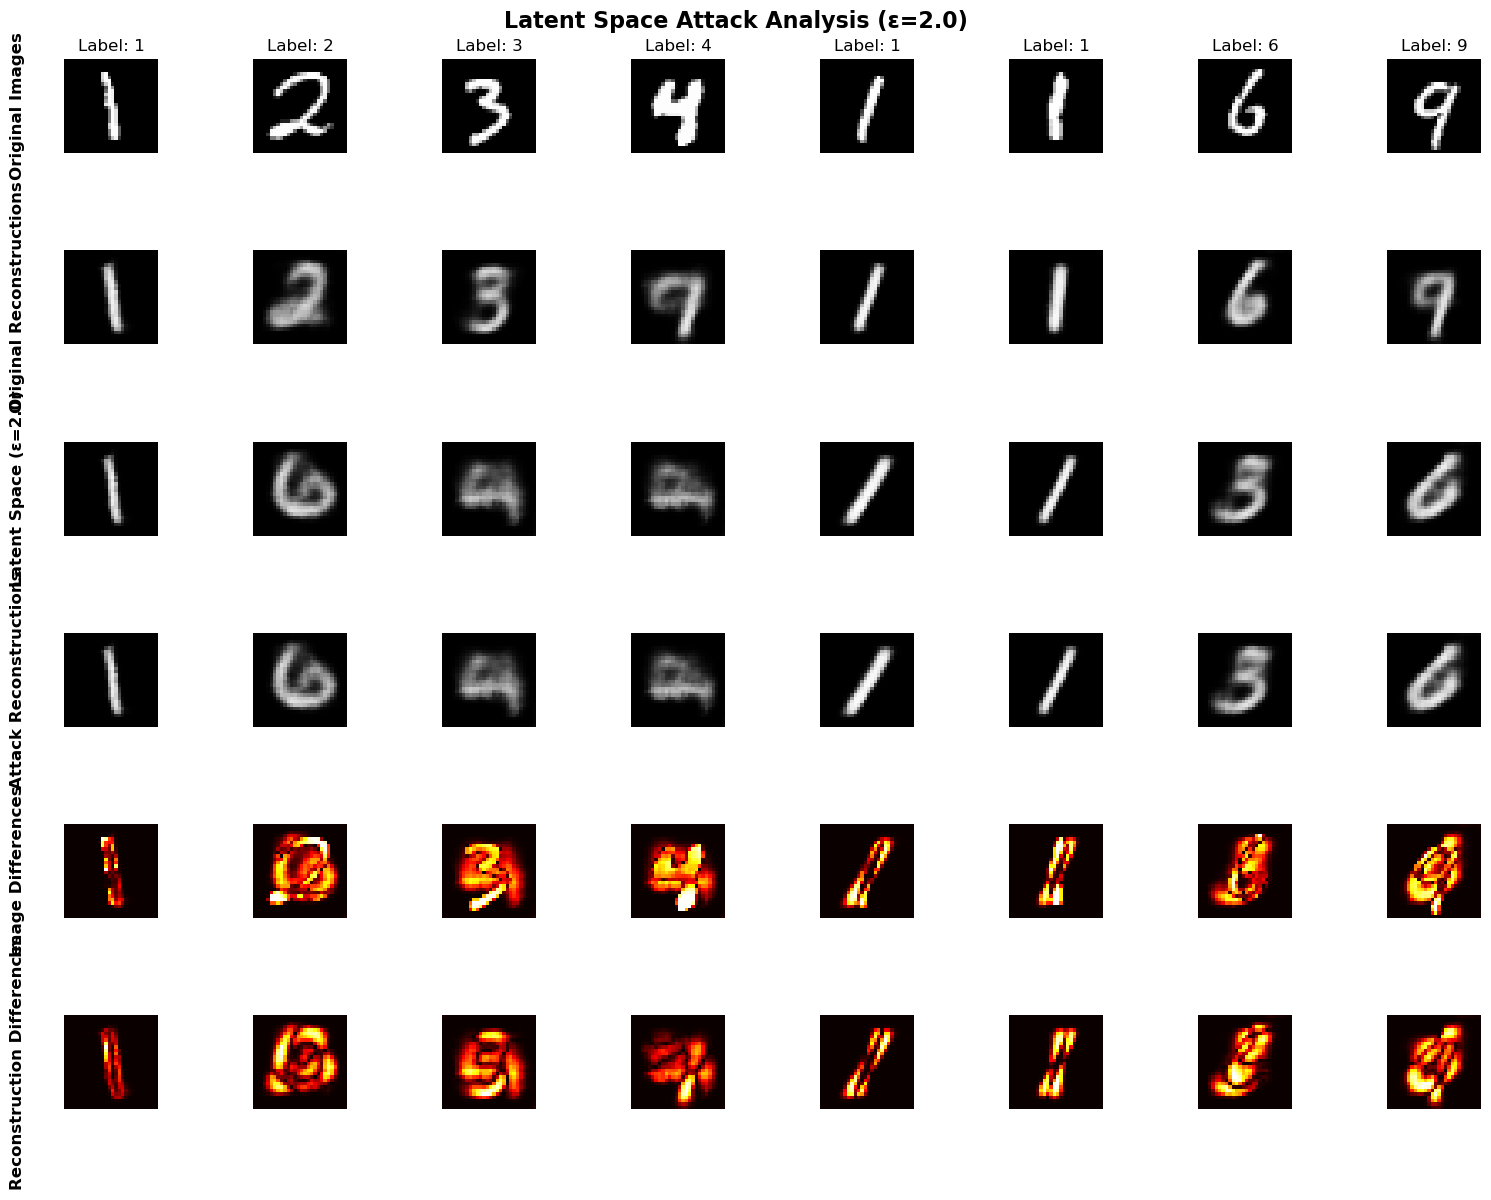

📊 Latent Space Attack Metrics (ε=2.0):
   Image MSE: 0.072449
   Reconstruction MSE: 0.044591
   Max image perturbation: 0.999896
   Max reconstruction change: 0.958400
   Attack success: ✅
--------------------------------------------------

🎯 Testing Latent Attack with epsilon = 3.0


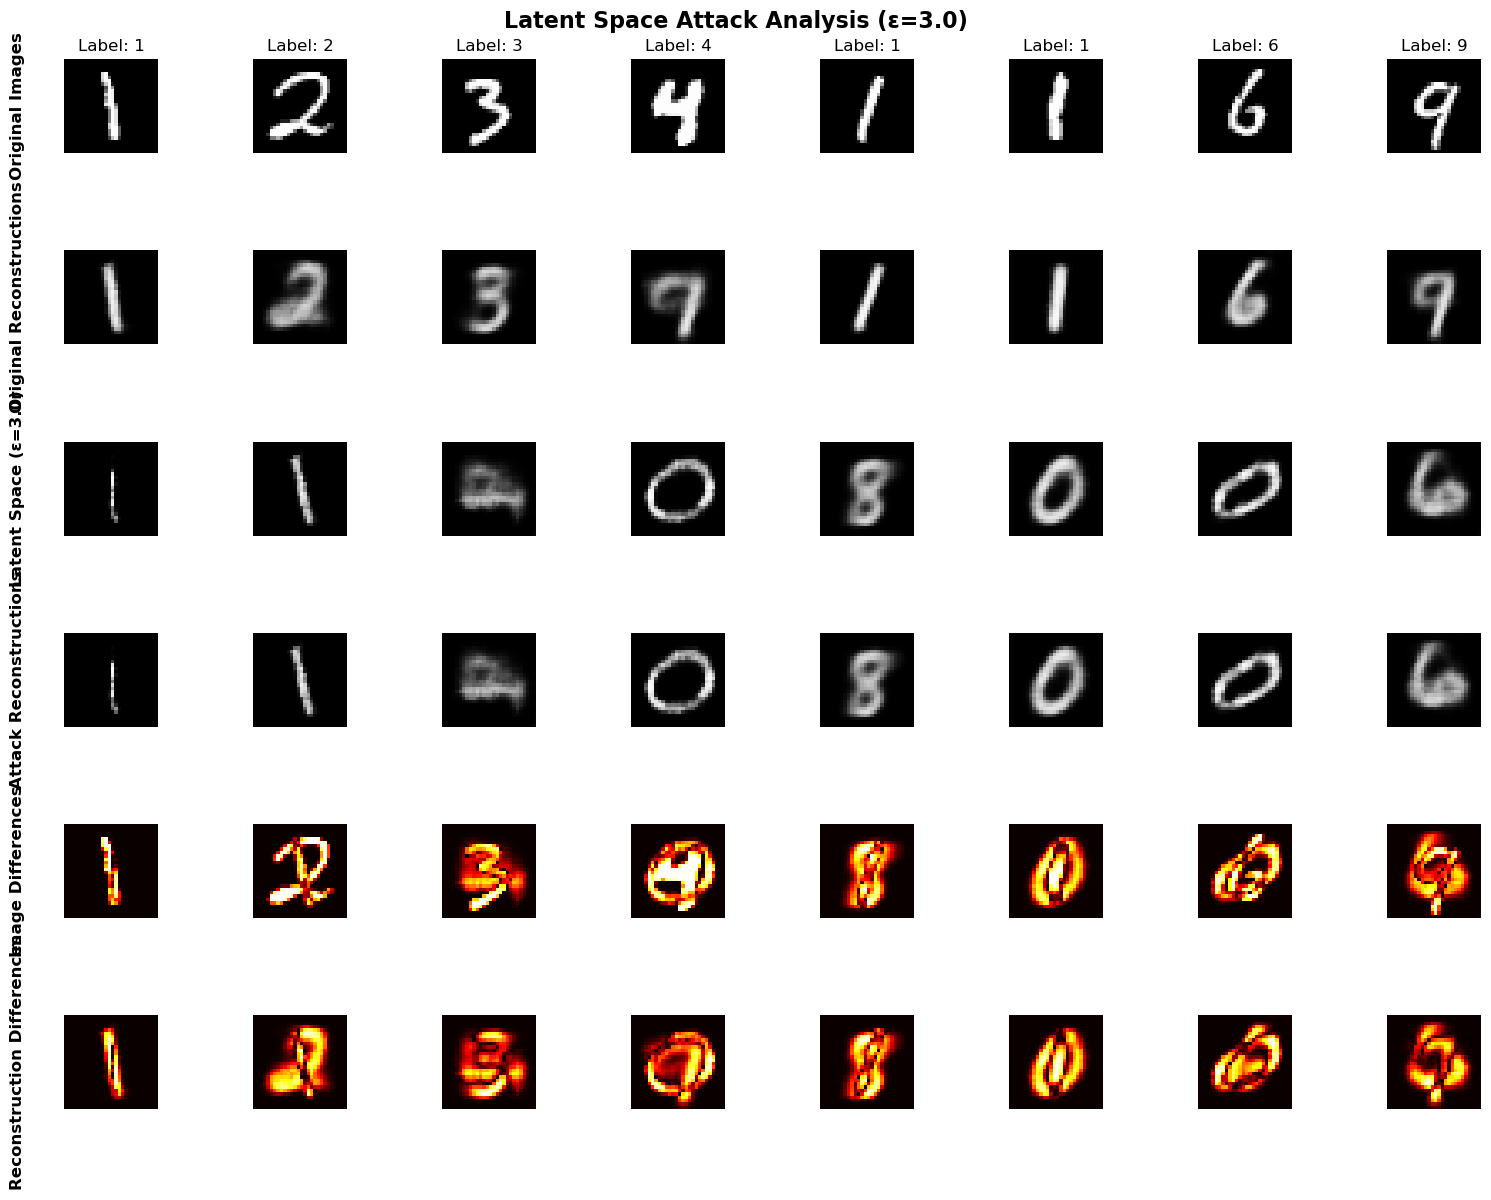

📊 Latent Space Attack Metrics (ε=3.0):
   Image MSE: 0.102083
   Reconstruction MSE: 0.072435
   Max image perturbation: 0.999990
   Max reconstruction change: 0.969564
   Attack success: ✅
--------------------------------------------------


In [16]:
# Latent Space Attack Analysis
print("🔥 Performing Latent Space Attack Analysis...")

latent_epsilons = [0.5, 1.0, 2.0, 3.0]

for epsilon in latent_epsilons:
    print(f"\n🎯 Testing Latent Attack with epsilon = {epsilon}")
    
    # Perform latent space attack
    latent_images, orig_latent, perturbed_latent = attacks.latent_space_attack(
        model, sample_images, epsilon
    )
    
    # Visualize attack analysis
    visualize_attack_analysis(
        sample_images, original_recons, latent_images, latent_images,
        "Latent Space", epsilon, sample_labels
    )

## 🔥 Custom Iterative Attack Analysis

Custom attack combining reconstruction and KL divergence targeting.

🔥 Performing Custom Iterative Attack Analysis...

🎯 Testing Custom Attack with epsilon = 0.05


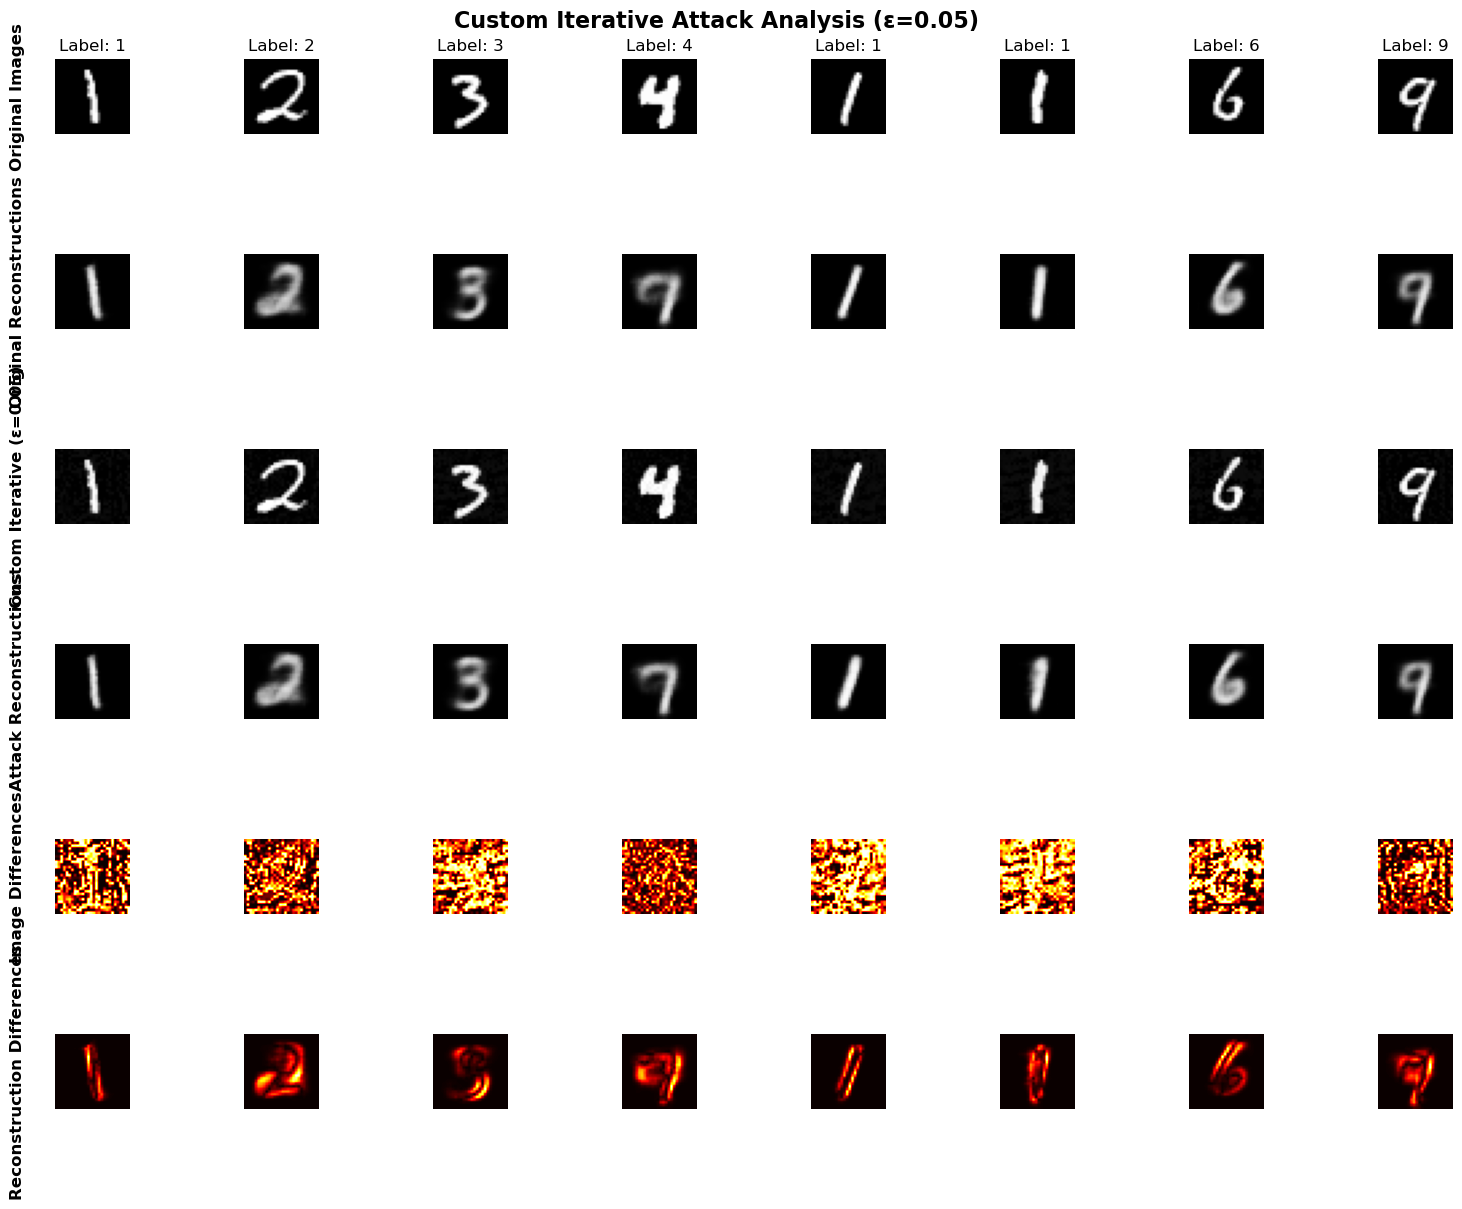

📊 Custom Iterative Attack Metrics (ε=0.05):
   Image MSE: 0.000823
   Reconstruction MSE: 0.003716
   Max image perturbation: 0.050000
   Max reconstruction change: 0.577015
   Attack success: ❌
--------------------------------------------------

🎯 Testing Custom Attack with epsilon = 0.1


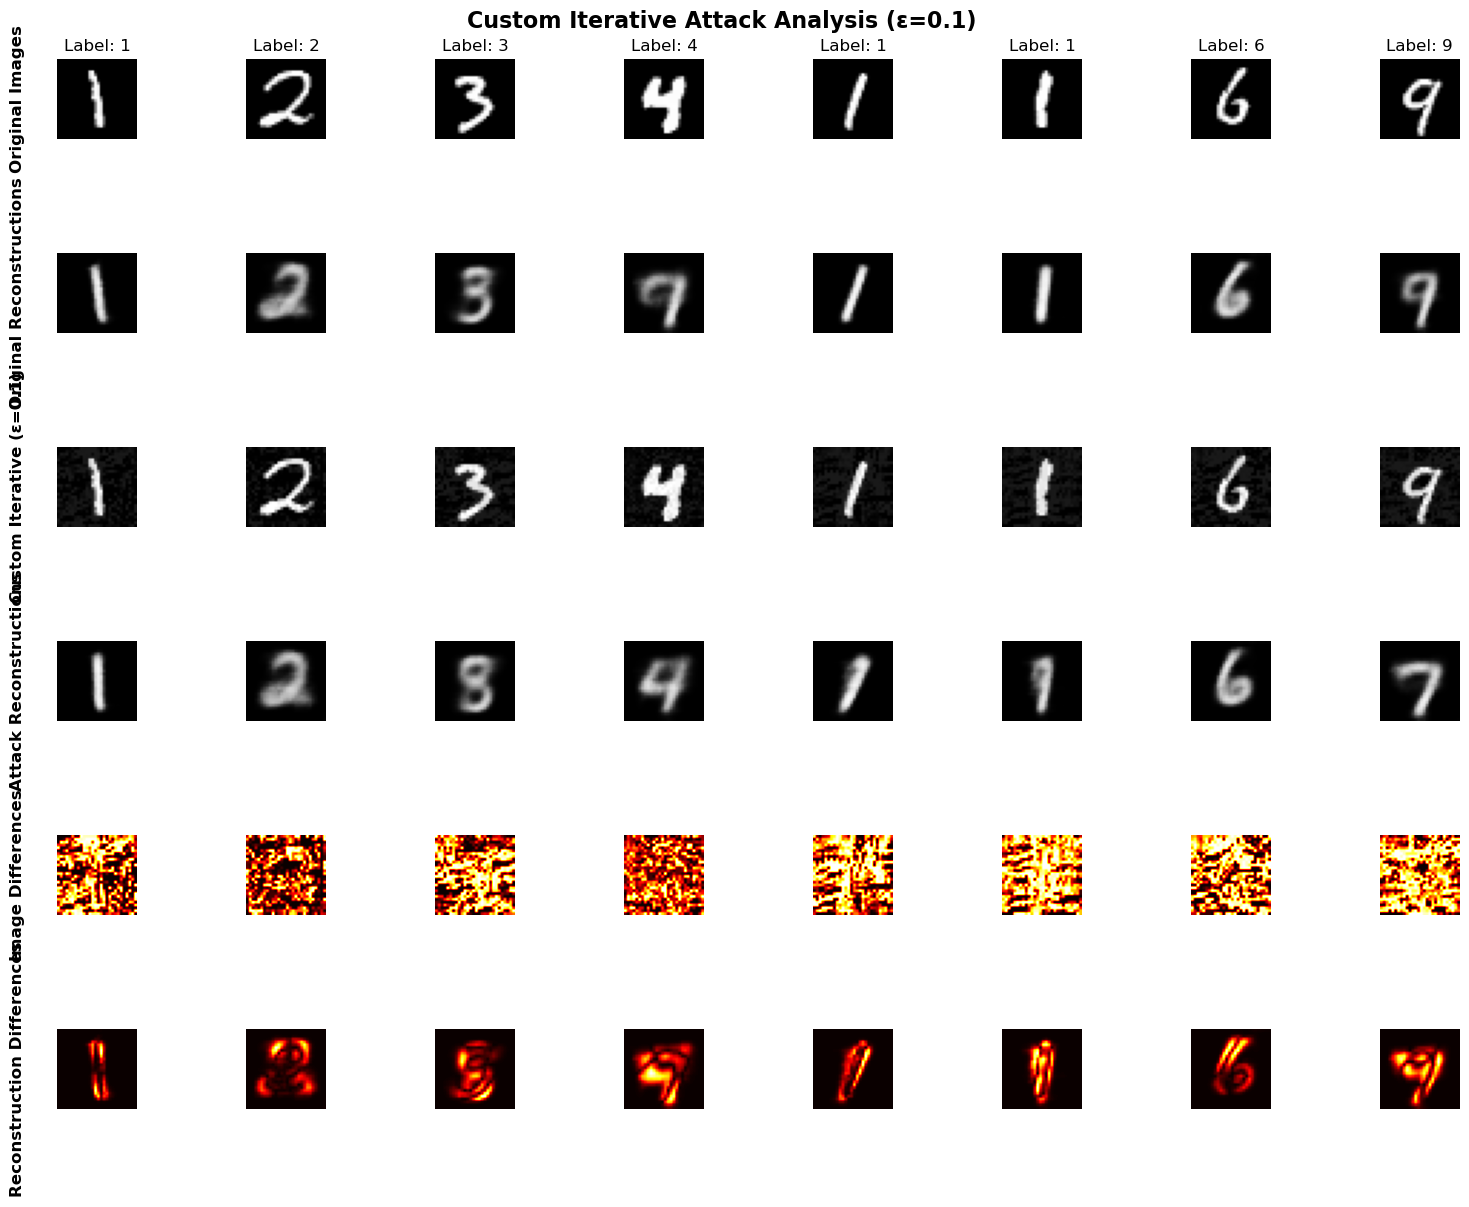

📊 Custom Iterative Attack Metrics (ε=0.1):
   Image MSE: 0.003831
   Reconstruction MSE: 0.013094
   Max image perturbation: 0.100000
   Max reconstruction change: 0.792651
   Attack success: ✅
--------------------------------------------------

🎯 Testing Custom Attack with epsilon = 0.15


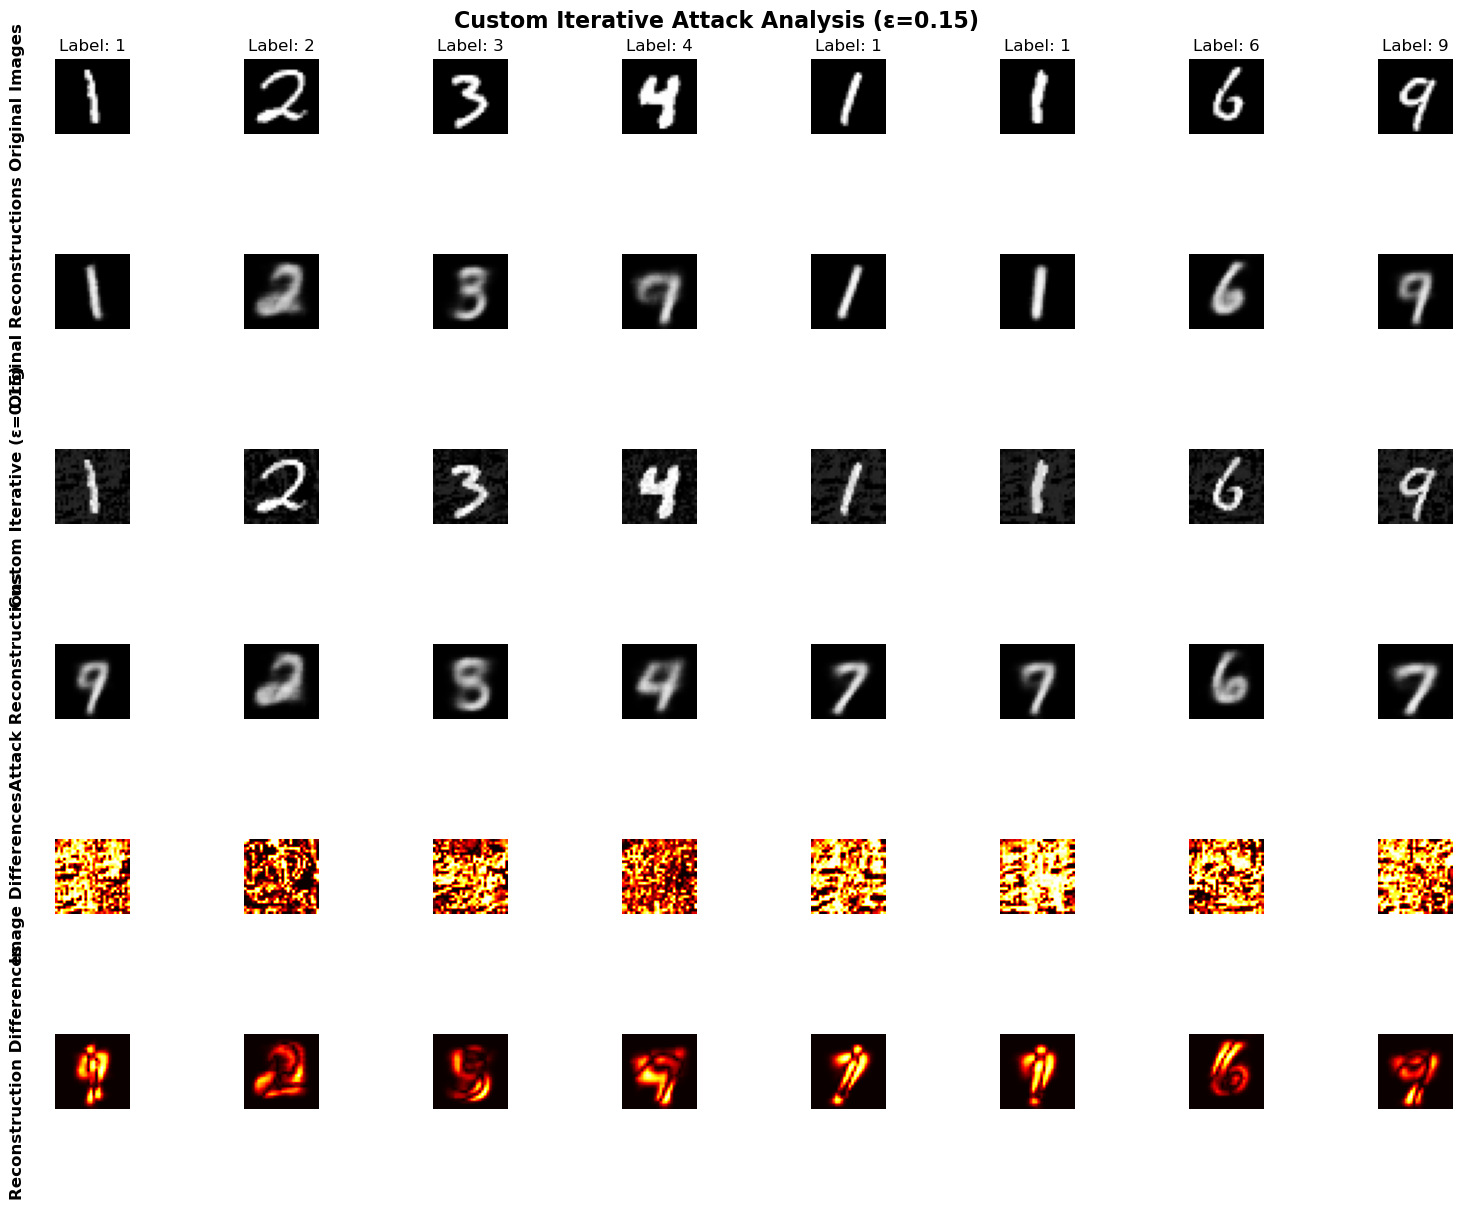

📊 Custom Iterative Attack Metrics (ε=0.15):
   Image MSE: 0.008920
   Reconstruction MSE: 0.032763
   Max image perturbation: 0.150000
   Max reconstruction change: 0.899085
   Attack success: ✅
--------------------------------------------------

🎯 Testing Custom Attack with epsilon = 0.2


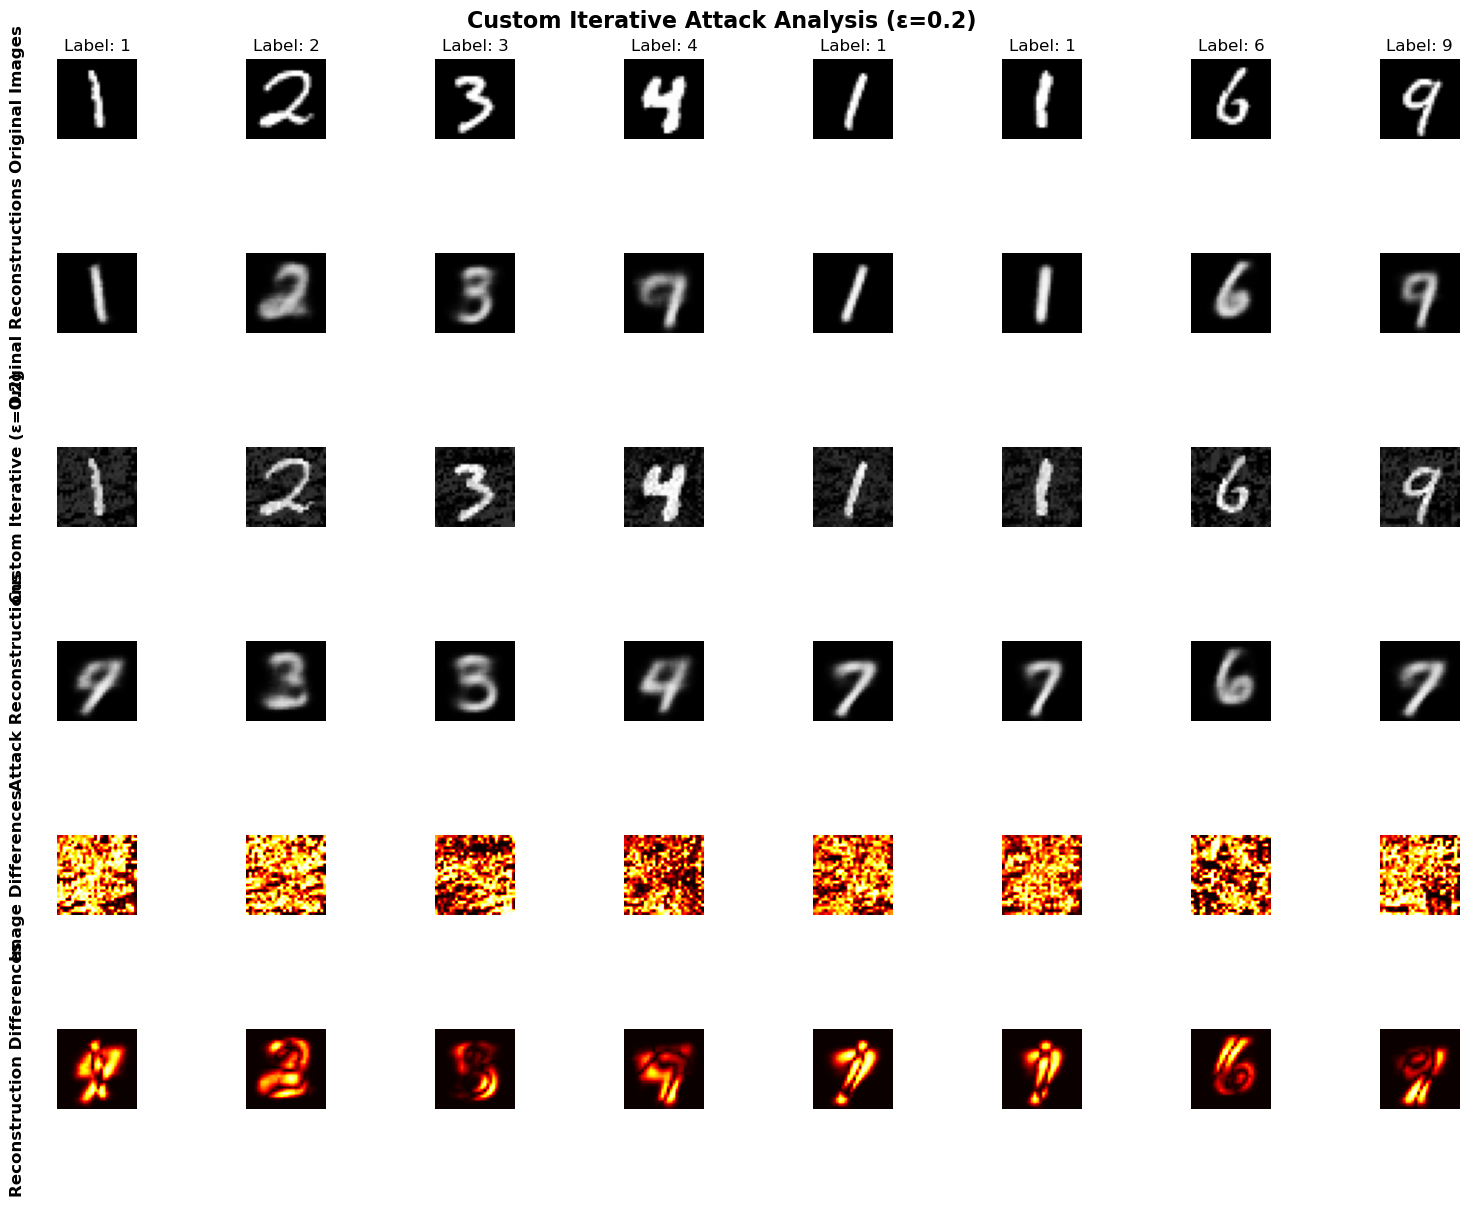

📊 Custom Iterative Attack Metrics (ε=0.2):
   Image MSE: 0.014595
   Reconstruction MSE: 0.043822
   Max image perturbation: 0.200000
   Max reconstruction change: 0.924159
   Attack success: ✅
--------------------------------------------------


In [17]:
# Custom Iterative Attack Analysis
print("🔥 Performing Custom Iterative Attack Analysis...")

for epsilon in CONFIG['attack_epsilons']:
    print(f"\n🎯 Testing Custom Attack with epsilon = {epsilon}")
    
    # Perform custom attack
    custom_images = custom_vae_attack(model, sample_images, epsilon, num_iter=15)
    
    # Get adversarial reconstructions
    with torch.no_grad():
        custom_recons, _, _ = model(custom_images)
    
    # Visualize attack analysis
    visualize_attack_analysis(
        sample_images, original_recons, custom_images, custom_recons,
        "Custom Iterative", epsilon, sample_labels
    )

## 📊 Attack Effectiveness Comparison

Compare different attack methods across various metrics.

In [18]:
# Attack Effectiveness Comparison
print("📊 Comparing Attack Effectiveness...")

comparison_results = compare_attack_effectiveness(model, sample_images, epsilon=0.1)

# Display results in table format
print("\n" + "="*80)
print("ATTACK EFFECTIVENESS COMPARISON (ε=0.1)")
print("="*80)
print(f"{'Attack':<15} {'Img MSE':<10} {'Img L∞':<10} {'Recon MSE':<12} {'Latent MSE':<12}")
print("-"*80)

for attack_name, metrics in comparison_results.items():
    print(f"{attack_name:<15} {metrics['img_mse']:<10.6f} {metrics['img_linf']:<10.6f} "
          f"{metrics['recon_mse']:<12.6f} {metrics['latent_mse']:<12.6f}")

print("="*80)
print("Metrics:")
print("- Img MSE: Mean squared error between original and adversarial images")
print("- Img L∞: Maximum absolute perturbation (should be ≤ ε)")
print("- Recon MSE: Difference in VAE reconstructions")
print("- Latent MSE: Difference in latent space representations")

📊 Comparing Attack Effectiveness...

ATTACK EFFECTIVENESS COMPARISON (ε=0.1)
Attack          Img MSE    Img L∞     Recon MSE    Latent MSE  
--------------------------------------------------------------------------------
FGSM            0.009527   0.100000   0.019604     0.172710    
PGD             0.004586   0.100000   0.018400     0.134224    
Custom          0.003680   0.100000   0.012903     0.137193    
Metrics:
- Img MSE: Mean squared error between original and adversarial images
- Img L∞: Maximum absolute perturbation (should be ≤ ε)
- Recon MSE: Difference in VAE reconstructions
- Latent MSE: Difference in latent space representations

ATTACK EFFECTIVENESS COMPARISON (ε=0.1)
Attack          Img MSE    Img L∞     Recon MSE    Latent MSE  
--------------------------------------------------------------------------------
FGSM            0.009527   0.100000   0.019604     0.172710    
PGD             0.004586   0.100000   0.018400     0.134224    
Custom          0.003680   0.1000

## 📈 Attack Success Rate Analysis

Analyze how attack success varies with perturbation strength and across different digits.

In [8]:
# Attack Success Rate Analysis
print("📈 Analyzing Attack Success Rates...")

# Define success criteria function
def attack_success_criterion(original_images, adversarial_images, original_recons, adversarial_recons, threshold=0.01):
    """Define when an attack is considered successful"""
    # Success if reconstruction MSE increases significantly
    orig_mse = F.mse_loss(original_images, original_recons).item()
    adv_mse = F.mse_loss(adversarial_images, adversarial_recons).item()
    return adv_mse > orig_mse + threshold

# Implement attack success rate analysis
def analyze_attack_success_rates_local(model, test_loader, epsilons, device, max_batches=5):
    """Analyze attack success rates across different epsilon values and digit classes"""
    attacks = AdversarialAttacks()
    results = {}
    total_samples = 0
    
    for eps in epsilons:
        results[eps] = {
            'fgsm': [],
            'pgd': [],
            'by_digit': {d: {'fgsm': [], 'pgd': []} for d in range(10)}
        }
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(test_loader):
            if batch_idx >= max_batches:
                break
                
            data = data.to(device)
            labels = labels.to(device)
            
            # Get original reconstructions
            original_recons, _, _ = model(data)
            
            total_samples += len(data)
            
            for eps in epsilons:
                # FGSM Attack
                fgsm_images = attacks.fgsm_attack(model, data, data, eps)
                fgsm_recons, _, _ = model(fgsm_images)
                
                # PGD Attack  
                pgd_images = attacks.pgd_attack(model, data, data, eps, alpha=eps/10, num_iter=10)
                pgd_recons, _, _ = model(pgd_images)
                
                # Evaluate success for each sample
                for i in range(len(data)):
                    digit = labels[i].item()
                    
                    # FGSM success
                    fgsm_success = attack_success_criterion(
                        data[i:i+1], fgsm_images[i:i+1], 
                        original_recons[i:i+1], fgsm_recons[i:i+1]
                    )
                    results[eps]['fgsm'].append(fgsm_success)
                    results[eps]['by_digit'][digit]['fgsm'].append(fgsm_success)
                    
                    # PGD success
                    pgd_success = attack_success_criterion(
                        data[i:i+1], pgd_images[i:i+1],
                        original_recons[i:i+1], pgd_recons[i:i+1]
                    )
                    results[eps]['pgd'].append(pgd_success)
                    results[eps]['by_digit'][digit]['pgd'].append(pgd_success)
    
    return results, total_samples

success_results, total_tested = analyze_attack_success_rates_local(
    model, test_loader, CONFIG['attack_epsilons'], device, max_batches=5
)

print(f"\nTested on {total_tested} samples")
print("\n" + "="*60)
print("ATTACK SUCCESS RATES BY EPSILON")
print("="*60)
print(f"{'Epsilon':<10} {'FGSM Success':<15} {'PGD Success':<15}")
print("-"*60)

for eps in CONFIG['attack_epsilons']:
    fgsm_rate = np.mean(success_results[eps]['fgsm']) * 100
    pgd_rate = np.mean(success_results[eps]['pgd']) * 100
    print(f"{eps:<10} {fgsm_rate:<15.1f}% {pgd_rate:<15.1f}%")

# Plot success rates
plt.figure(figsize=(12, 5))

# Overall success rates
plt.subplot(1, 2, 1)
epsilons = CONFIG['attack_epsilons']
fgsm_rates = [np.mean(success_results[eps]['fgsm']) * 100 for eps in epsilons]
pgd_rates = [np.mean(success_results[eps]['pgd']) * 100 for eps in epsilons]

plt.plot(epsilons, fgsm_rates, 'o-', label='FGSM', linewidth=2, markersize=8)
plt.plot(epsilons, pgd_rates, 's-', label='PGD', linewidth=2, markersize=8)
plt.xlabel('Epsilon (Perturbation Strength)')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate vs Epsilon')
plt.legend()
plt.grid(True, alpha=0.3)

# Success rates by digit (for epsilon=0.1)
plt.subplot(1, 2, 2)
eps = 0.1
digits = list(range(10))
fgsm_by_digit = [np.mean(success_results[eps]['by_digit'][d]['fgsm']) * 100 
                 if success_results[eps]['by_digit'][d]['fgsm'] else 0 for d in digits]
pgd_by_digit = [np.mean(success_results[eps]['by_digit'][d]['pgd']) * 100 
                if success_results[eps]['by_digit'][d]['pgd'] else 0 for d in digits]

x = np.arange(len(digits))
width = 0.35

plt.bar(x - width/2, fgsm_by_digit, width, label='FGSM', alpha=0.8)
plt.bar(x + width/2, pgd_by_digit, width, label='PGD', alpha=0.8)
plt.xlabel('Digit Class')
plt.ylabel('Attack Success Rate (%)')
plt.title(f'Attack Success by Digit Class (ε={eps})')
plt.xticks(x, digits)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📈 Analyzing Attack Success Rates...


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## 🚀 Comprehensive Attack Efficiency Analysis

Evaluate attack efficiency across the entire test dataset with detailed epsilon scaling.

🚀 Starting comprehensive attack efficiency analysis...
Testing 20 epsilon values: 0.010 to 0.300
📊 Collecting test samples...
Testing on 1000 samples
Getting original reconstructions...

🔥 Testing epsilon = 0.010 (1/20)
  Running FGSM...

🔥 Testing epsilon = 0.010 (1/20)
  Running FGSM...
  Running PGD...
  Running PGD...
  Running Custom...
  Running Custom...

🔥 Testing epsilon = 0.025 (2/20)
  Running FGSM...
  Running PGD...
  Running Custom...

🔥 Testing epsilon = 0.025 (2/20)
  Running FGSM...
  Running PGD...
  Running Custom...

🔥 Testing epsilon = 0.041 (3/20)
  Running FGSM...
  Running PGD...
  Running Custom...

🔥 Testing epsilon = 0.041 (3/20)
  Running FGSM...
  Running PGD...
  Running Custom...

🔥 Testing epsilon = 0.056 (4/20)
  Running FGSM...
  Running PGD...
  Running Custom...

🔥 Testing epsilon = 0.056 (4/20)
  Running FGSM...
  Running PGD...
  Running Custom...

🔥 Testing epsilon = 0.071 (5/20)
  Running FGSM...
  Running PGD...
  Running Custom...

🔥 Testing ep

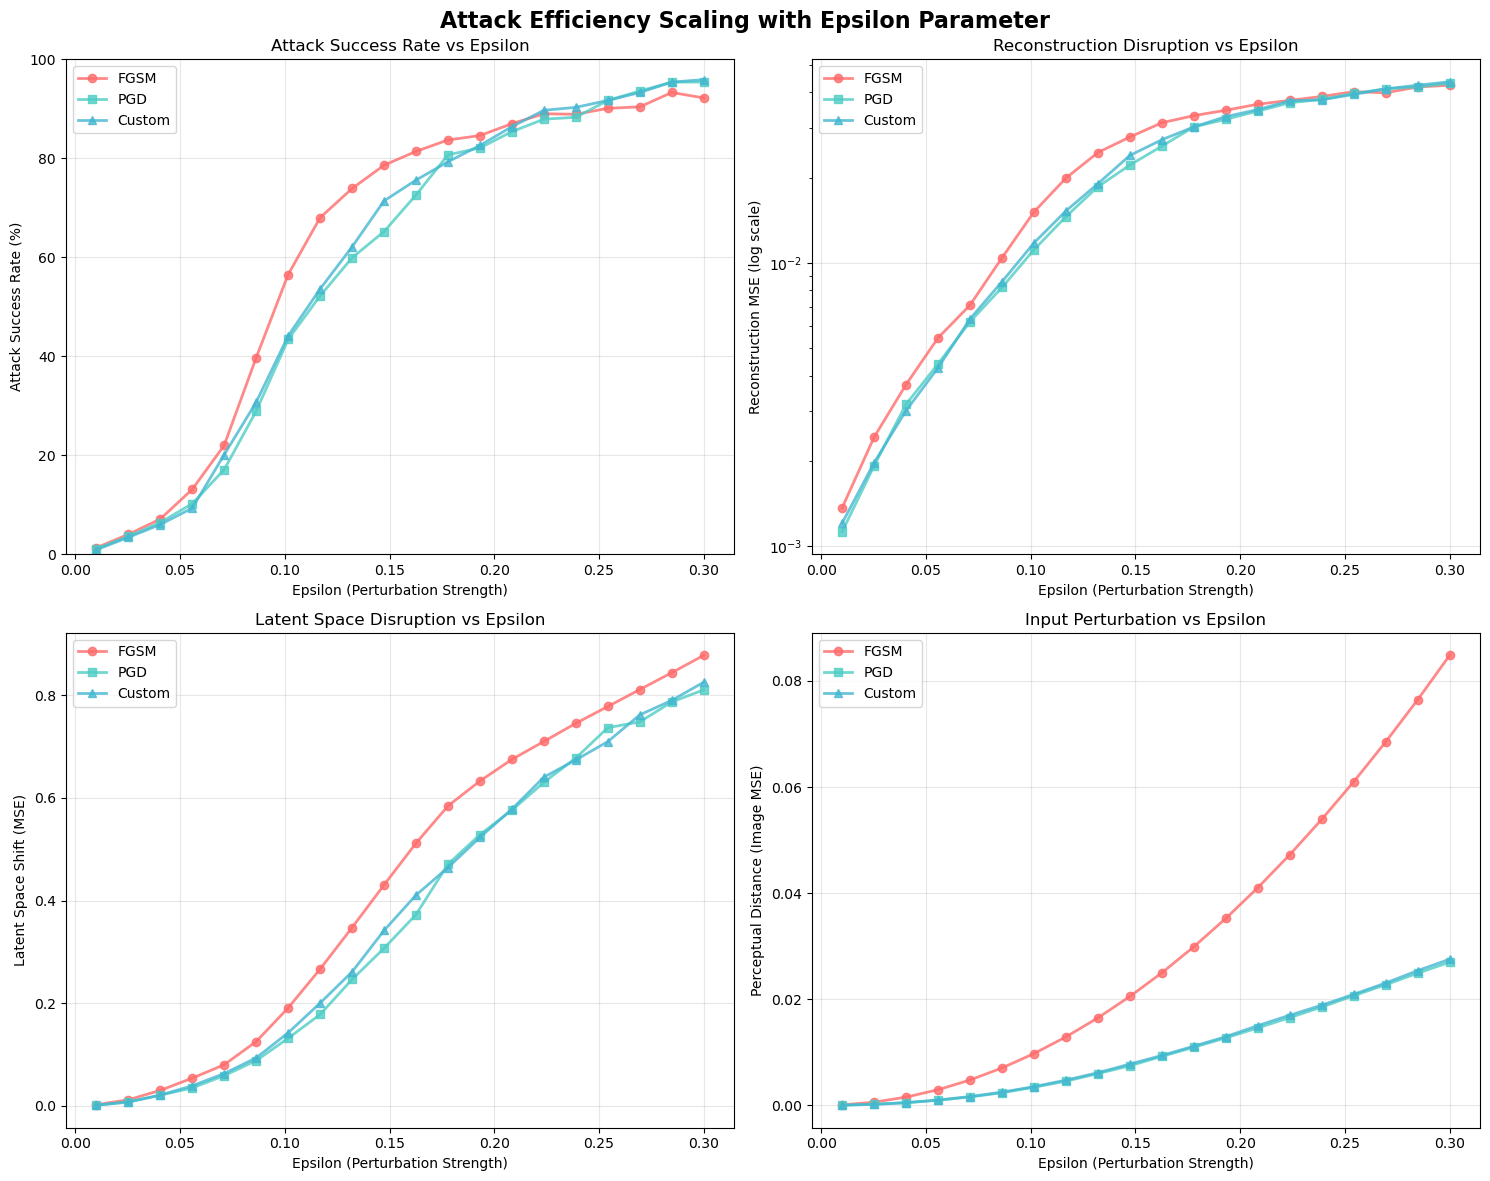


🎯 Creating simple efficiency summary plot...


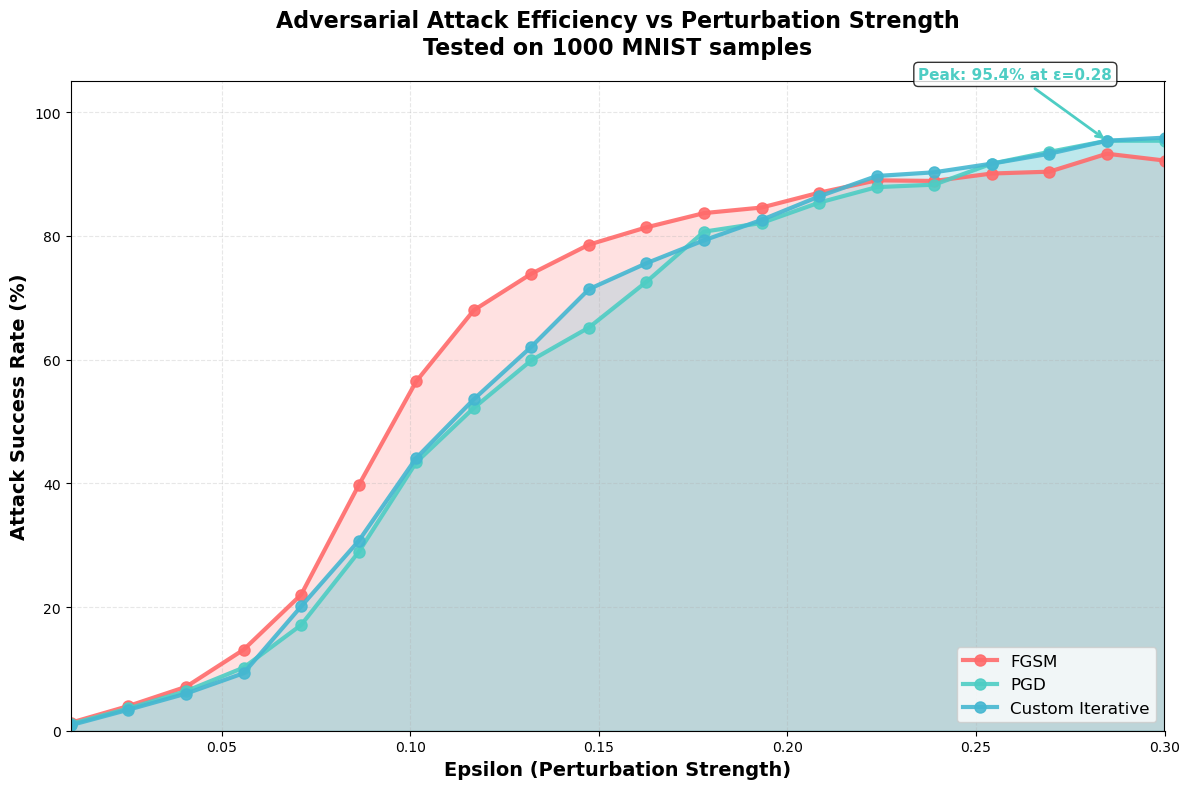

In [10]:
# Comprehensive Attack Efficiency Analysis
epsilon_range = np.linspace(0.01, 0.3, 20)  # 20 points from 0.01 to 0.3

print("🚀 Starting comprehensive attack efficiency analysis...")
print(f"Testing {len(epsilon_range)} epsilon values: {epsilon_range[0]:.3f} to {epsilon_range[-1]:.3f}")

# Run the analysis
efficiency_results = comprehensive_attack_efficiency(
    model, test_loader, epsilon_range, device, max_samples=CONFIG['efficiency_samples']
)

print(f"\n✅ Analysis complete! Tested on {efficiency_results['sample_count']} samples")

# Create efficiency scaling plots
print("\n📈 Creating efficiency scaling visualizations...")
plot_attack_efficiency_scaling(efficiency_results)

# Create simple summary plot
print("\n🎯 Creating simple efficiency summary plot...")
plot_simple_efficiency_summary(efficiency_results)

## 🔥 Efficiency Heatmap Analysis

Create detailed heatmaps showing attack efficiency patterns across epsilon values and methods.

In [ ]:
# Create efficiency heatmaps
print("🔥 Creating Efficiency Heatmaps...")

# Install seaborn if not available (for heatmap visualization)
try:
    import seaborn as sns
    print("✅ Seaborn available for heatmap creation")
except ImportError:
    print("⚠️ Installing seaborn for better heatmap visualization...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
    import seaborn as sns
    print("✅ Seaborn installed successfully")

# Create comprehensive heatmaps
create_efficiency_heatmap(efficiency_results)

print("\n📊 Heatmap Analysis Complete:")
print("   • Reconstruction error heatmap shows attack effectiveness")
print("   • Latent space disruption heatmap shows representation impact")
print("   • Darker colors indicate higher disruption/effectiveness")

## 📈 Detailed Efficiency Scaling Analysis

Comprehensive multi-panel analysis showing how attack efficiency scales across all metrics.

In [ ]:
# Create detailed efficiency scaling plots
print("📈 Creating Detailed Efficiency Scaling Analysis...")

# Generate comprehensive 4-panel efficiency plot
plot_efficiency_scaling(efficiency_results, save_path=f"efficiency_scaling_{model_timestamp}.png")

print("\n📊 Detailed Scaling Analysis Complete:")
print("   • Panel 1: Reconstruction MSE - Shows how reconstruction quality degrades")
print("   • Panel 2: Latent Space MSE - Shows latent representation disruption")
print("   • Panel 3: Input Perturbation MSE - Shows actual input modifications")
print("   • Panel 4: Efficiency Ratio - Shows attack effectiveness vs perturbation cost")
print(f"   • Plot saved as: efficiency_scaling_{model_timestamp}.png")

## 💾 Save Efficiency Analysis

Save the comprehensive efficiency analysis results for future reference and comparison.

In [ ]:
# Save comprehensive efficiency analysis
print("💾 Saving Comprehensive Efficiency Analysis...")

# Save the efficiency results
efficiency_save_file = save_efficiency_analysis(
    efficiency_results, 
    model_timestamp, 
    analysis_type='comprehensive_efficiency'
)

# Display summary statistics
print(f"\n📊 Efficiency Analysis Summary:")
print(f"   • Epsilon range: {len(efficiency_results['epsilons'])} points from {efficiency_results['epsilons'][0]:.3f} to {efficiency_results['epsilons'][-1]:.3f}")
print(f"   • Samples analyzed: {efficiency_results['sample_count']}")
print(f"   • Attack methods tested: {len([m for m in ['fgsm', 'pgd', 'custom'] if m in efficiency_results])}")

# Calculate peak efficiency points
attack_methods = ['fgsm', 'pgd', 'custom']
print(f"\n🎯 Peak Efficiency Points:")
for method in attack_methods:
    if method in efficiency_results and 'recon_mse' in efficiency_results[method]:
        recon_errors = efficiency_results[method]['recon_mse']
        if hasattr(recon_errors, '__len__') and len(recon_errors) > 0:
            max_idx = np.argmax(recon_errors)
            peak_epsilon = efficiency_results['epsilons'][max_idx]
            peak_error = recon_errors[max_idx]
            print(f"   • {method.upper()}: ε={peak_epsilon:.3f} (recon_mse={peak_error:.6f})")

print(f"\n💾 Results saved to: {efficiency_save_file}")
print("✅ Comprehensive efficiency analysis complete!")

## 🎯 Latent Space Clustering Analysis

Analyze how adversarial attacks affect digit clustering in the 2D latent space.

🎯 Starting Latent Space Clustering Analysis
🔍 Collecting digit samples by class...
  Digit 0: 12 samples
  Digit 1: 12 samples
  Digit 2: 12 samples
  Digit 3: 12 samples
  Digit 4: 12 samples
  Digit 5: 12 samples
  Digit 6: 12 samples
  Digit 7: 12 samples
  Digit 8: 12 samples
  Digit 9: 12 samples

ANALYZING FGSM ATTACK
🎯 Analyzing latent clustering under FGSM attack (ε=0.15)
  Processing digit 0: 12 samples
  Processing digit 1: 12 samples
  Processing digit 2: 12 samples
  Processing digit 3: 12 samples
  Processing digit 4: 12 samples
  Processing digit 5: 12 samples
  Processing digit 6: 12 samples
  Processing digit 7: 12 samples
  Processing digit 8: 12 samples
  Processing digit 9: 12 samples


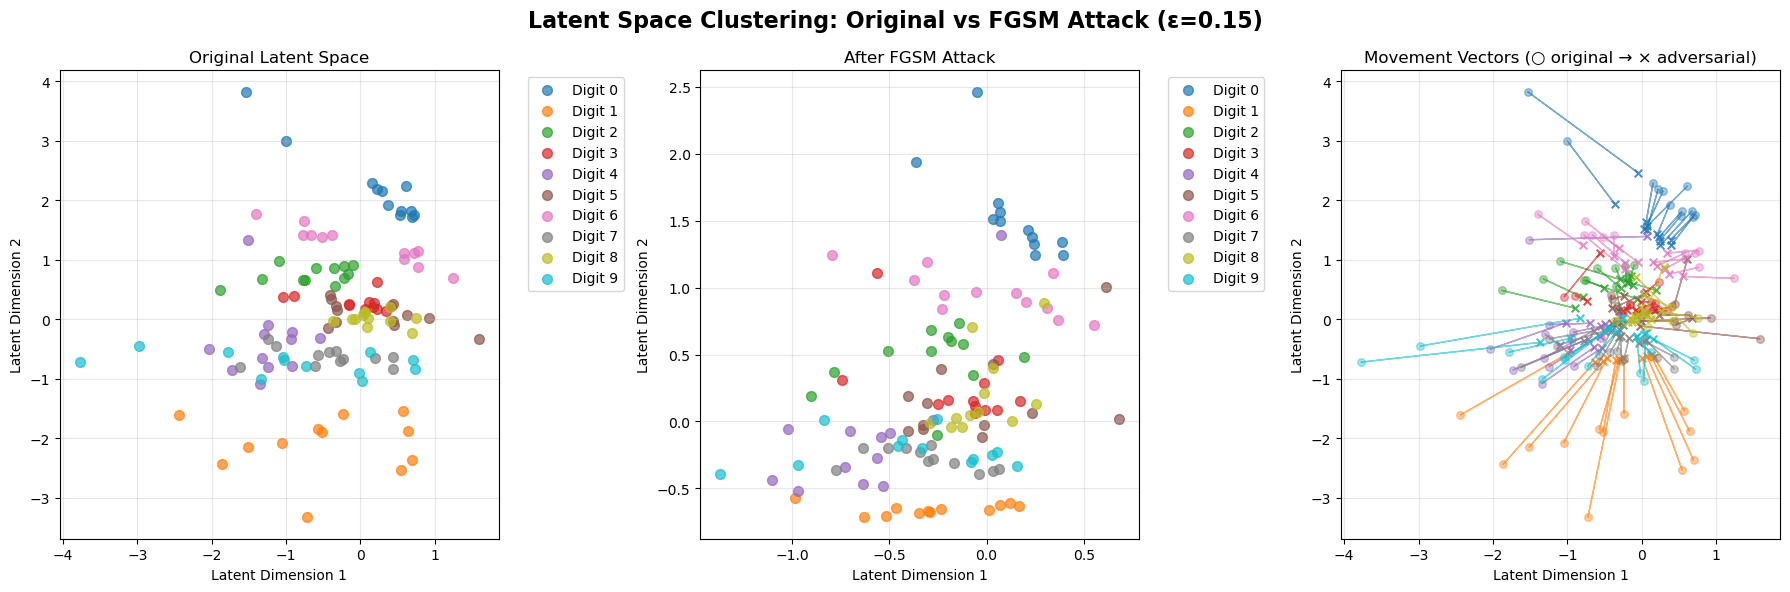


LATENT SPACE CLUSTERING ANALYSIS

Centroid Movements for FGSM Attack (ε=0.15):
------------------------------------------------------------
  Digit 0: Centroid moved 0.6638 units
  Digit 1: Centroid moved 1.4765 units
  Digit 2: Centroid moved 0.4585 units
  Digit 3: Centroid moved 0.0992 units
  Digit 4: Centroid moved 0.6825 units
  Digit 5: Centroid moved 0.2467 units
  Digit 6: Centroid moved 0.2918 units
  Digit 7: Centroid moved 0.3774 units
  Digit 8: Centroid moved 0.2677 units
  Digit 9: Centroid moved 0.7568 units

Overall Statistics:
  Average centroid movement: 0.5321
  Max centroid movement: 1.4765
  Min centroid movement: 0.0992
  Std deviation: 0.3753

Intra-class Scatter Changes:
----------------------------------------
  Digit 0: Scatter changed by -54.8% (0.6601 → 0.2984)
  Digit 1: Scatter changed by -73.8% (1.0019 → 0.2625)
  Digit 2: Scatter changed by -29.5% (0.4572 → 0.3222)
  Digit 3: Scatter changed by -20.1% (0.3711 → 0.2967)
  Digit 4: Scatter changed by -28

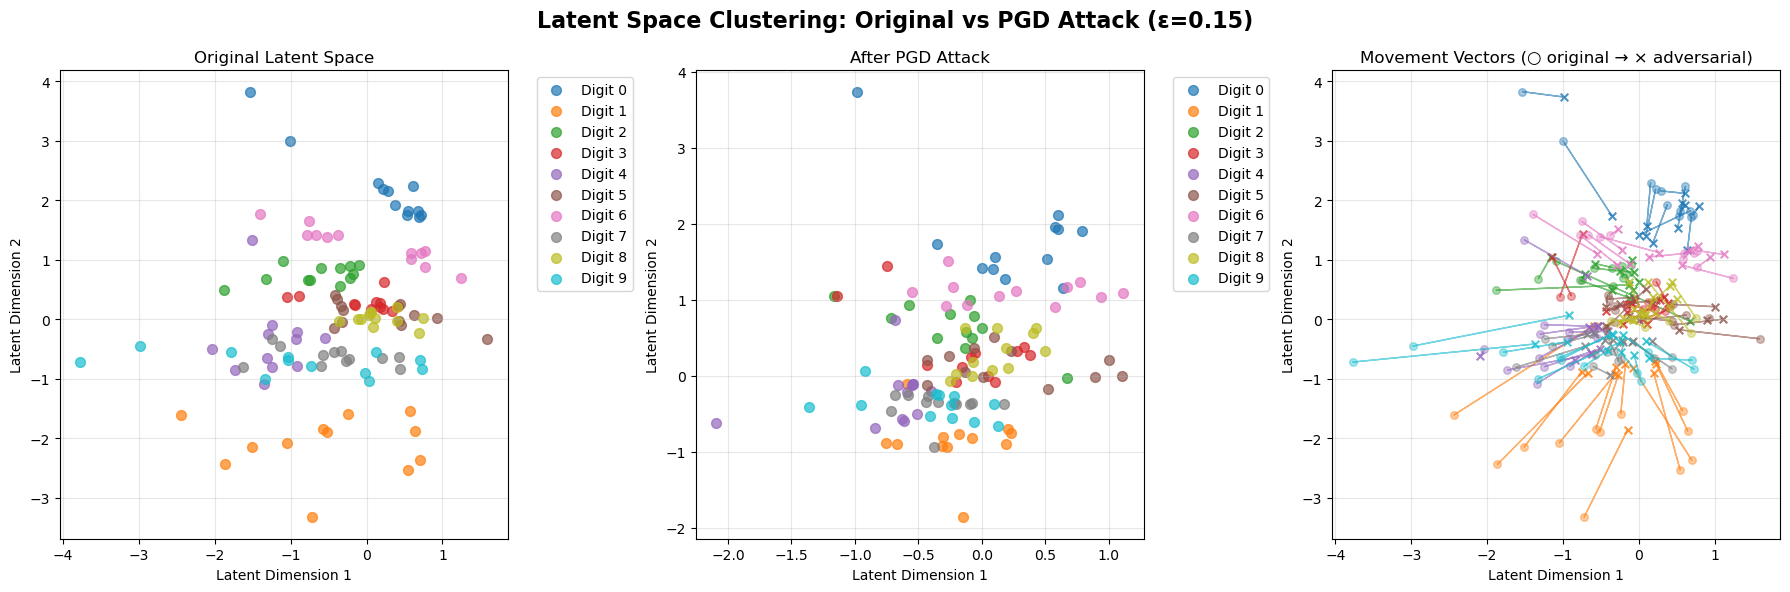


LATENT SPACE CLUSTERING ANALYSIS

Centroid Movements for PGD Attack (ε=0.15):
------------------------------------------------------------
  Digit 0: Centroid moved 0.4008 units
  Digit 1: Centroid moved 1.2852 units
  Digit 2: Centroid moved 0.4253 units
  Digit 3: Centroid moved 0.1136 units
  Digit 4: Centroid moved 0.5466 units
  Digit 5: Centroid moved 0.0707 units
  Digit 6: Centroid moved 0.2815 units
  Digit 7: Centroid moved 0.2642 units
  Digit 8: Centroid moved 0.2807 units
  Digit 9: Centroid moved 0.6311 units

Overall Statistics:
  Average centroid movement: 0.4300
  Max centroid movement: 1.2852
  Min centroid movement: 0.0707
  Std deviation: 0.3298

Intra-class Scatter Changes:
----------------------------------------
  Digit 0: Scatter changed by -4.8% (0.6601 → 0.6284)
  Digit 1: Scatter changed by -60.7% (1.0019 → 0.3939)
  Digit 2: Scatter changed by -10.1% (0.4572 → 0.4109)
  Digit 3: Scatter changed by +34.5% (0.3711 → 0.4991)
  Digit 4: Scatter changed by -26.5

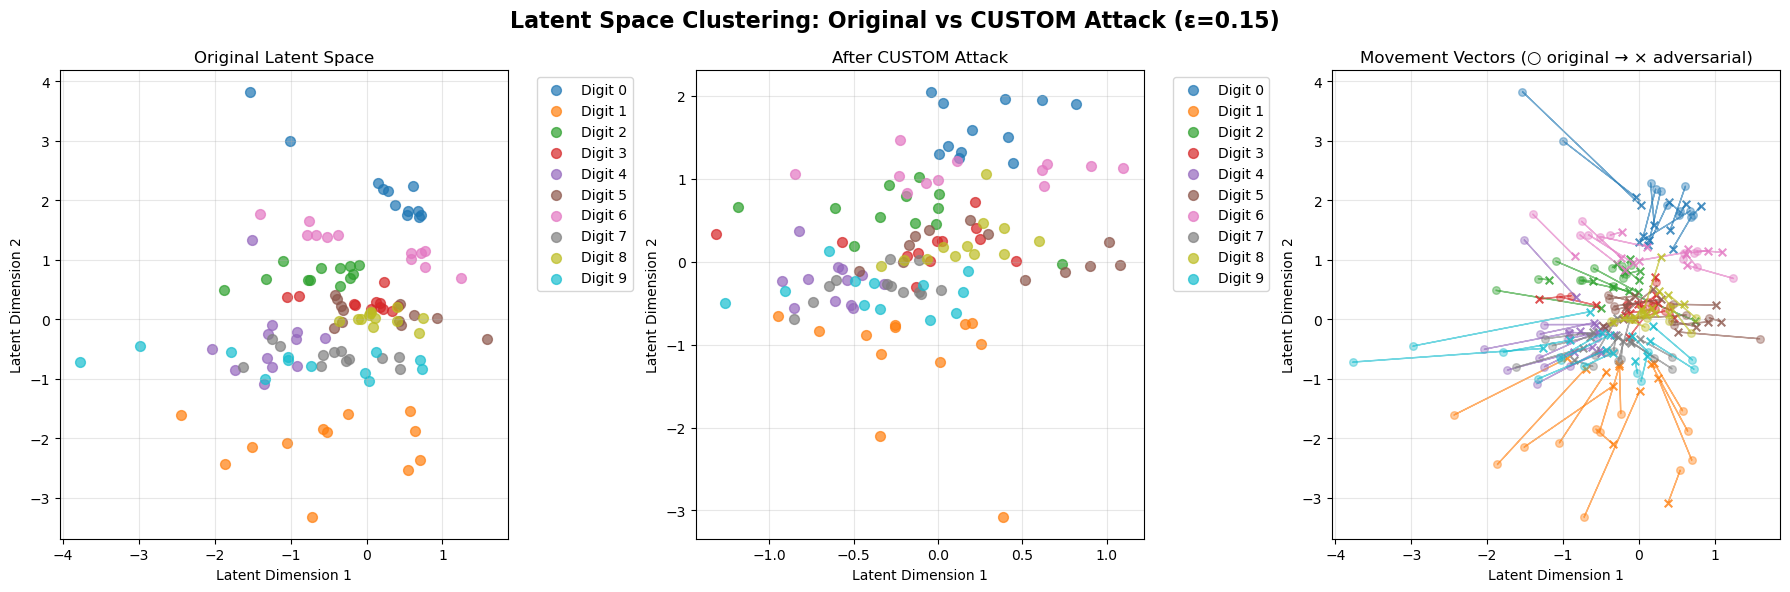


LATENT SPACE CLUSTERING ANALYSIS

Centroid Movements for CUSTOM Attack (ε=0.15):
------------------------------------------------------------
  Digit 0: Centroid moved 0.6027 units
  Digit 1: Centroid moved 1.0111 units
  Digit 2: Centroid moved 0.4601 units
  Digit 3: Centroid moved 0.1007 units
  Digit 4: Centroid moved 0.6451 units
  Digit 5: Centroid moved 0.1311 units
  Digit 6: Centroid moved 0.2523 units
  Digit 7: Centroid moved 0.3367 units
  Digit 8: Centroid moved 0.2237 units
  Digit 9: Centroid moved 0.6897 units

Overall Statistics:
  Average centroid movement: 0.4453
  Max centroid movement: 1.0111
  Min centroid movement: 0.1007
  Std deviation: 0.2757

Intra-class Scatter Changes:
----------------------------------------
  Digit 0: Scatter changed by -42.9% (0.6601 → 0.3772)
  Digit 1: Scatter changed by -37.0% (1.0019 → 0.6308)
  Digit 2: Scatter changed by -8.0% (0.4572 → 0.4206)
  Digit 3: Scatter changed by +8.1% (0.3711 → 0.4010)
  Digit 4: Scatter changed by -52

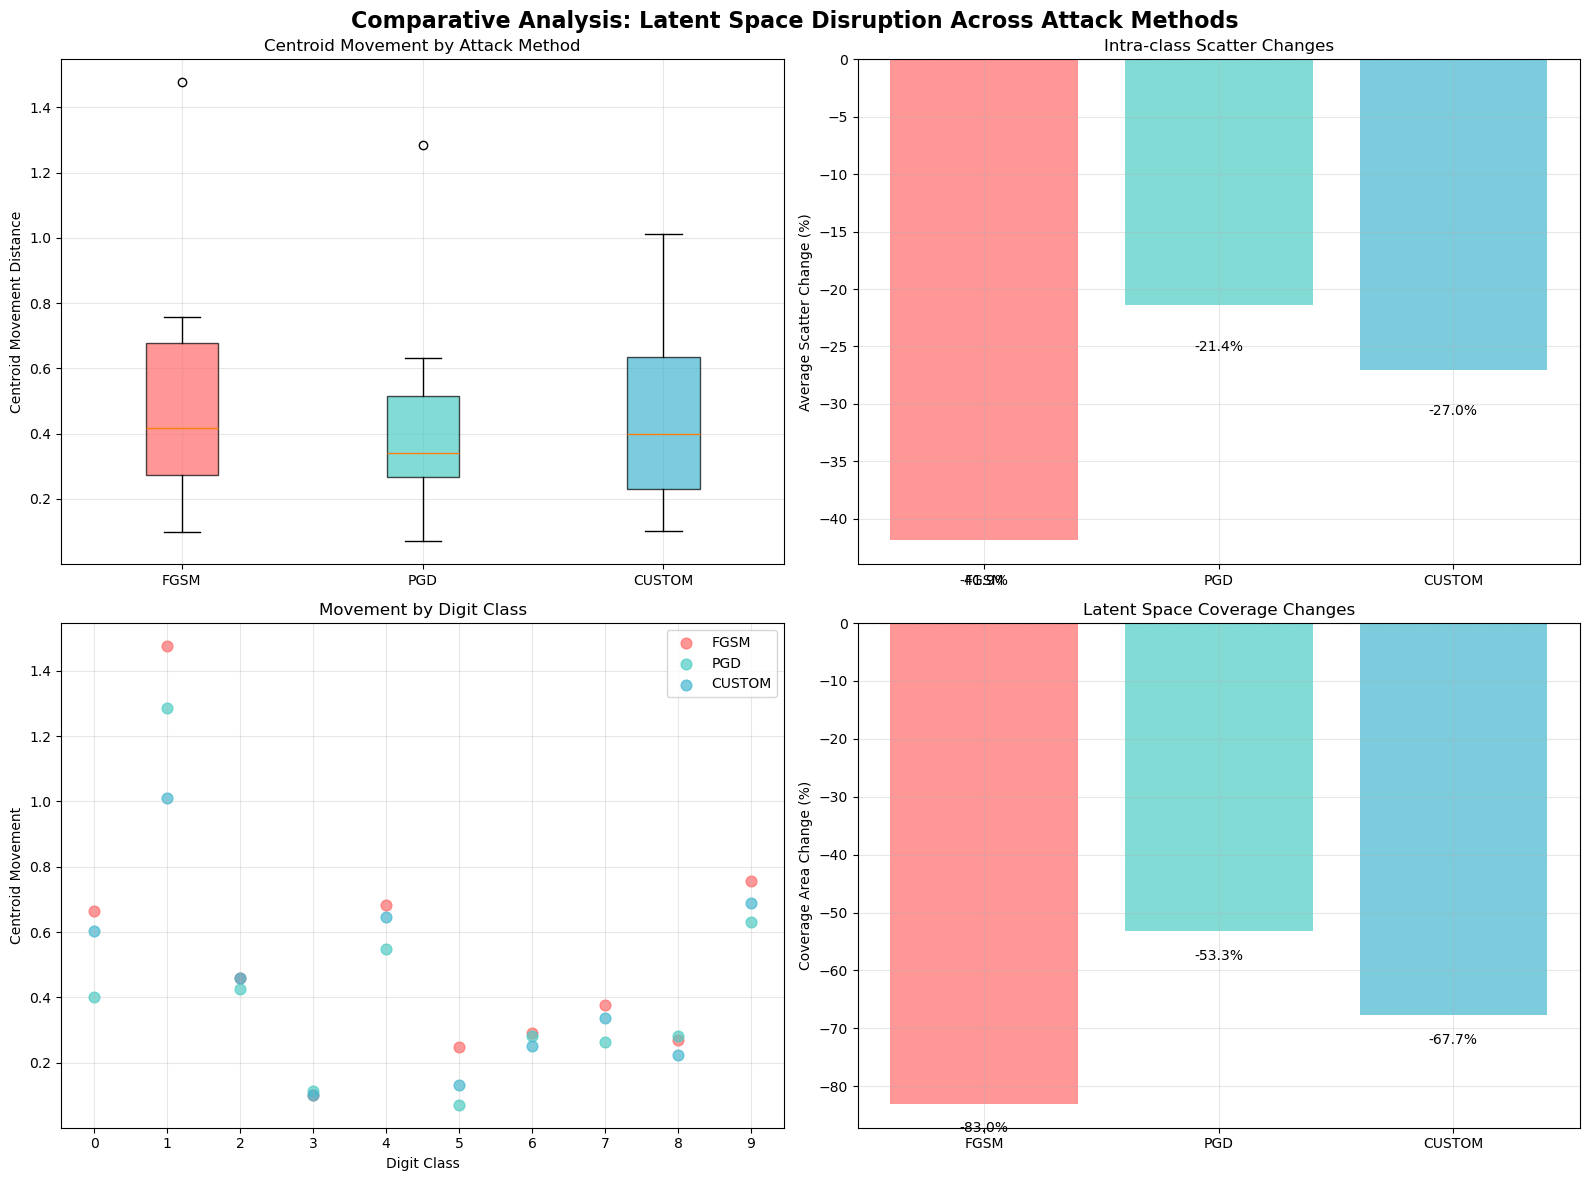

In [9]:
# Latent Space Clustering Analysis
print("🎯 Starting Latent Space Clustering Analysis")
print("=" * 60)

# Sample digits from test dataset
digit_samples = sample_digits_by_class(
    test_loader, device, 
    samples_per_class=CONFIG['clustering_samples'], 
    max_batches=15
)

# Analyze clustering under different attacks
attack_methods = ['fgsm', 'pgd', 'custom']
epsilon_test = 0.15  # Use moderate epsilon for clear visualization
clustering_analyses = {}

for attack_method in attack_methods:
    print(f"\n{'='*50}")
    print(f"ANALYZING {attack_method.upper()} ATTACK")
    print(f"{'='*50}")
    
    # Perform clustering analysis
    clustering_results = analyze_latent_clustering_under_attack(
        model, digit_samples, attack_method=attack_method, epsilon=epsilon_test
    )
    
    # Store results
    clustering_analyses[attack_method] = clustering_results
    
    # Plot the results
    plot_latent_clustering_comparison(clustering_results)

# Comparative analysis
print("\n🔬 Creating comparative analysis...")
compare_latent_disruption_across_attacks(clustering_analyses)

## 💾 Save Analysis Results

Save all analysis results for future reference and comparison.

In [10]:
# Save comprehensive analysis results
print("💾 Saving analysis results...")

# Save different analysis results
analysis_files = []

# Save attack effectiveness comparison
effectiveness_file = save_analysis_results(
    comparison_results, model_timestamp, 'attack_effectiveness'
)
analysis_files.append(effectiveness_file)

# Save success rate analysis
success_data = {
    'config': CONFIG,
    'success_rates': {str(k): v for k, v in success_results.items()},
    'total_samples_tested': total_tested
}
success_file = save_analysis_results(
    success_data, model_timestamp, 'success_rates'
)
analysis_files.append(success_file)

# Save efficiency analysis
efficiency_data = {
    'sample_count': efficiency_results['sample_count'],
    'epsilon_range': efficiency_results['epsilons'].tolist(),
    'attacks': {name: data for name, data in efficiency_results.items() 
                if name not in ['epsilons', 'sample_count']}
}
efficiency_file = save_analysis_results(
    efficiency_data, model_timestamp, 'attack_efficiency'
)
analysis_files.append(efficiency_file)

# Save clustering analysis
clustering_data = {
    'epsilon_tested': epsilon_test,
    'attacks': {}
}

for method, results in clustering_analyses.items():
    clustering_data['attacks'][method] = {
        'attack_info': results['attack_info'],
        'centroid_movements': {},
        'scatter_changes': {}
    }
    
    # Calculate summary statistics
    for digit in range(10):
        if (digit in results['original']['latent'] and 
            digit in results['adversarial']['latent']):
            
            orig_centroid = np.mean(results['original']['latent'][digit], axis=0)
            adv_centroid = np.mean(results['adversarial']['latent'][digit], axis=0)
            movement = np.linalg.norm(adv_centroid - orig_centroid)
            
            orig_points = results['original']['latent'][digit]
            adv_points = results['adversarial']['latent'][digit]
            orig_scatter = np.mean(np.linalg.norm(orig_points - orig_centroid, axis=1))
            adv_scatter = np.mean(np.linalg.norm(adv_points - adv_centroid, axis=1))
            scatter_change = ((adv_scatter - orig_scatter) / orig_scatter) * 100
            
            clustering_data['attacks'][method]['centroid_movements'][str(digit)] = float(movement)
            clustering_data['attacks'][method]['scatter_changes'][str(digit)] = float(scatter_change)

clustering_file = save_analysis_results(
    clustering_data, model_timestamp, 'latent_clustering'
)
analysis_files.append(clustering_file)

# Print comprehensive summary
print("\n" + "="*80)
print("COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS COMPLETE")
print("="*80)
print(f"\n🔍 Analysis Summary:")
print(f"   • Visual attack analysis with 6-row comparative visualization")
print(f"   • Attack effectiveness comparison across FGSM, PGD, and Custom methods")
print(f"   • Success rate analysis across {len(CONFIG['attack_epsilons'])} epsilon values")
print(f"   • Comprehensive efficiency scaling with {len(epsilon_range)} epsilon points")
print(f"   • Latent space clustering analysis for {len(attack_methods)} attack methods")
print(f"   • Tested on {efficiency_results['sample_count']} samples for efficiency analysis")

print(f"\n💾 Analysis files saved:")
for file in analysis_files:
    print(f"   📁 {file}")

print(f"\n🔗 Model analyzed: {model_timestamp}")
print("\n✅ Complete adversarial vulnerability assessment finished!")
print("🛡️ Ready for defense strategy development!")

💾 Saving analysis results...


NameError: name 'comparison_results' is not defined

## 🎭 Adversarial Image Generation: Non-MNIST Images That Fool the VAE

Create images that look nothing like MNIST digits but are still interpreted by the VAE as specific digit classes. This demonstrates how we can exploit the latent space structure to create convincing "fake" digits.

🎭 Starting adversarial image generation...
Target digits: [0, 1, 2, 7, 9]
🎯 Finding typical latent positions for target digits...
   Digit 0: centroid at (0.19, 2.18)
   Digit 1: centroid at (-0.36, -2.17)
   Digit 2: centroid at (-0.44, 0.66)
   Digit 7: centroid at (-0.47, -0.73)
   Digit 9: centroid at (-1.13, -0.70)

🎨 Generating fooling images for digits: [0, 1, 2, 7, 9]

🎯 Generating fooling image for digit 0...
   Digit 0: centroid at (0.19, 2.18)
   Digit 1: centroid at (-0.36, -2.17)
   Digit 2: centroid at (-0.44, 0.66)
   Digit 7: centroid at (-0.47, -0.73)
   Digit 9: centroid at (-1.13, -0.70)

🎨 Generating fooling images for digits: [0, 1, 2, 7, 9]

🎯 Generating fooling image for digit 0...
   Iteration 0: Loss = 2.292177 (Latent: 2.3561, Recon: 0.2740)
   Iteration 0: Loss = 2.292177 (Latent: 2.3561, Recon: 0.2740)
   Iteration 200: Loss = nan (Latent: 5.0560, Recon: nan)
   Iteration 200: Loss = nan (Latent: 5.0560, Recon: nan)
   Iteration 400: Loss = nan (Latent: 5.05

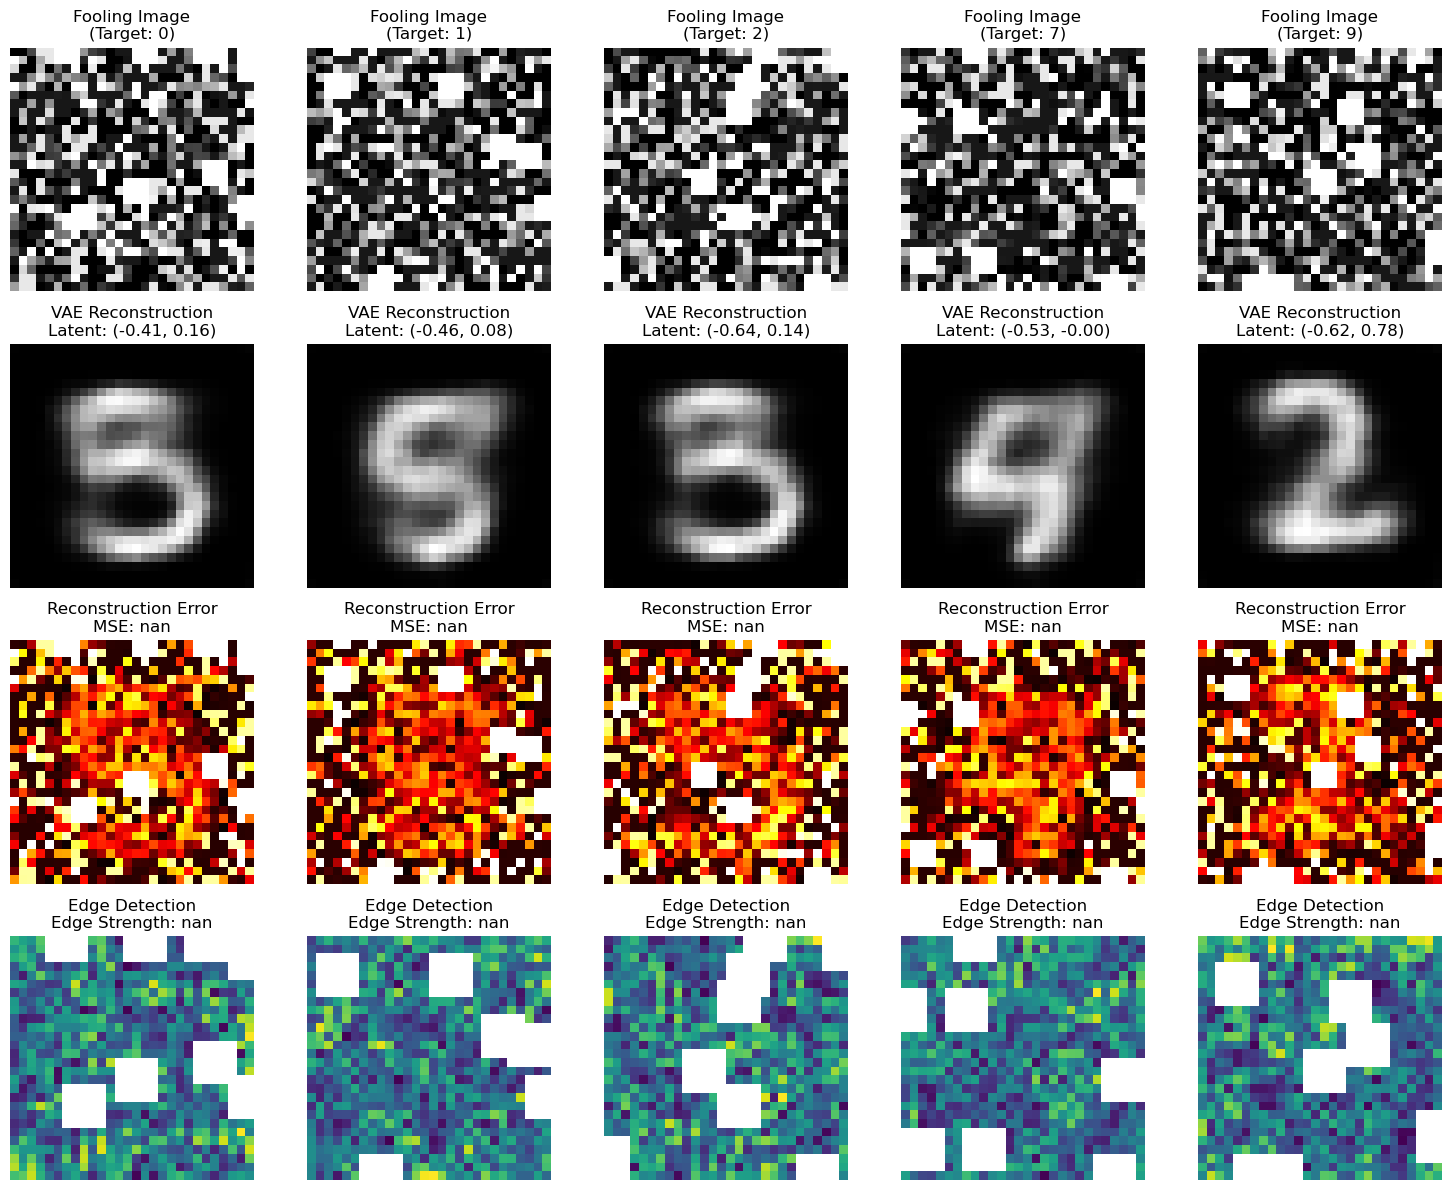

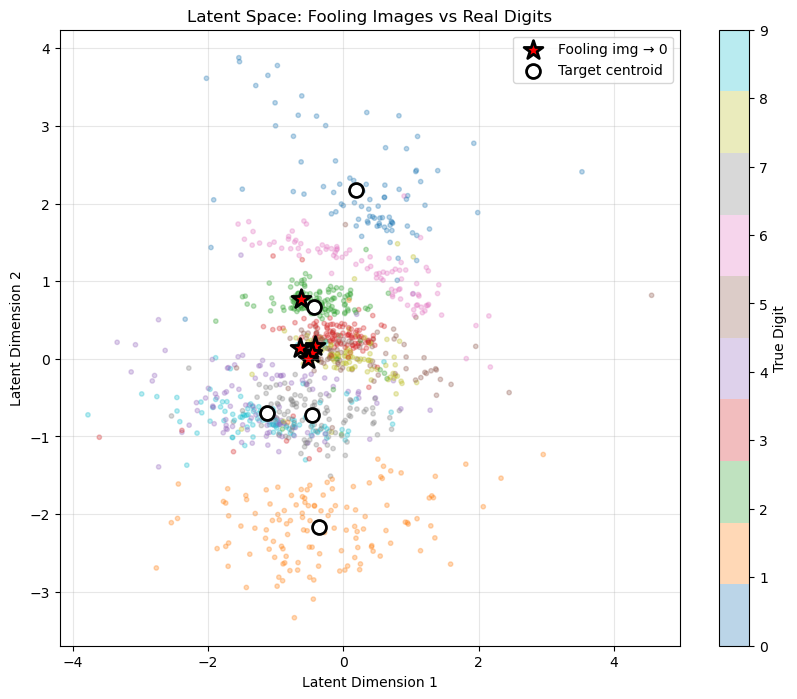

In [11]:
def generate_fooling_images(model, target_digits, device, num_iterations=1000, lr=0.1):
    """
    Generate images that don't look like MNIST digits but fool the VAE into 
    thinking they represent specific target digits.
    
    Strategy:
    1. Start with random noise
    2. Optimize the image to minimize reconstruction loss when decoded from target digit latent positions
    3. Add constraints to make images look non-digit-like
    """
    model.eval()
    fooling_images = []
    target_positions = []
    
    # Get typical latent positions for each target digit from real data
    print("🎯 Finding typical latent positions for target digits...")
    digit_latent_positions = {}
    
    with torch.no_grad():
        sample_count = 0
        for data, labels in test_loader:
            if sample_count >= 500:  # Limit samples
                break
            data = data.to(device)
            labels = labels.to(device)
            mu, _ = model.encoder(data)
            
            for i, label in enumerate(labels):
                digit = label.item()
                if digit in target_digits:
                    if digit not in digit_latent_positions:
                        digit_latent_positions[digit] = []
                    digit_latent_positions[digit].append(mu[i].cpu().numpy())
            
            sample_count += len(data)
    
    # Calculate centroids for each digit
    digit_centroids = {}
    for digit in target_digits:
        if digit in digit_latent_positions:
            positions = np.array(digit_latent_positions[digit])
            centroid = torch.tensor(np.mean(positions, axis=0), dtype=torch.float32, device=device)
            digit_centroids[digit] = centroid
            print(f"   Digit {digit}: centroid at ({centroid[0]:.2f}, {centroid[1]:.2f})")
    
    print(f"\n🎨 Generating fooling images for digits: {target_digits}")
    
    for digit in target_digits:
        if digit not in digit_centroids:
            print(f"⚠️ Skipping digit {digit} - insufficient data")
            continue
            
        print(f"\n🎯 Generating fooling image for digit {digit}...")
        
        # Initialize with random noise
        fooling_img = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)
        target_latent = digit_centroids[digit].unsqueeze(0)
        
        # Optimizer for the image
        optimizer = torch.optim.Adam([fooling_img], lr=lr)
        
        best_loss = float('inf')
        best_img = None
        
        for iteration in range(num_iterations):
            optimizer.zero_grad()
            
            # Clamp image to valid range
            with torch.no_grad():
                fooling_img.data = torch.clamp(fooling_img.data, 0, 1)
            
            # Encode the current image
            mu, logvar = model.encoder(fooling_img)
            
            # Loss 1: Distance to target latent position
            latent_loss = F.mse_loss(mu, target_latent)
            
            # Loss 2: Reconstruction consistency (image should reconstruct to itself via target latent)
            reconstructed = model.decoder(target_latent)
            reconstruction_loss = F.mse_loss(reconstructed, fooling_img)
            
            # Loss 3: Non-digit-like constraint (encourage high-frequency patterns)
            # Apply edge detection to penalize digit-like smooth regions
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=device).view(1, 1, 3, 3)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=device).view(1, 1, 3, 3)
            
            edges_x = F.conv2d(fooling_img, sobel_x, padding=1)
            edges_y = F.conv2d(fooling_img, sobel_y, padding=1)
            edge_magnitude = torch.sqrt(edges_x**2 + edges_y**2)
            
            # Encourage edges (non-smooth patterns)
            edge_loss = -torch.mean(edge_magnitude)  # Negative to maximize edges
            
            # Loss 4: Encourage specific non-digit patterns
            # Create checkerboard-like or striped patterns
            center_region = fooling_img[:, :, 8:20, 8:20]  # Focus on center
            pattern_loss = -torch.var(center_region)  # Encourage variation
            
            # Combine losses
            total_loss = (latent_loss + 
                         0.5 * reconstruction_loss + 
                         0.1 * edge_loss + 
                         0.1 * pattern_loss)
            
            total_loss.backward()
            optimizer.step()
            
            # Track best result
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_img = fooling_img.detach().clone()
            
            if iteration % 200 == 0:
                print(f"   Iteration {iteration}: Loss = {total_loss.item():.6f} "
                      f"(Latent: {latent_loss.item():.4f}, Recon: {reconstruction_loss.item():.4f})")
        
        # Store results
        fooling_images.append(best_img)
        target_positions.append(target_latent)
        
        print(f"✅ Generated fooling image for digit {digit} (final loss: {best_loss:.6f})")
    
    return fooling_images, target_positions, digit_centroids


def visualize_fooling_images(model, fooling_images, target_digits, digit_centroids, device):
    """Visualize the generated fooling images and their effects"""
    model.eval()
    
    n_images = len(fooling_images)
    fig, axes = plt.subplots(4, n_images, figsize=(3*n_images, 12))
    
    if n_images == 1:
        axes = axes.reshape(-1, 1)
    
    with torch.no_grad():
        for i, (fooling_img, digit) in enumerate(zip(fooling_images, target_digits)):
            # Original fooling image
            img_np = fooling_img.cpu().squeeze().numpy()
            axes[0, i].imshow(img_np, cmap='gray')
            axes[0, i].set_title(f'Fooling Image\n(Target: {digit})')
            axes[0, i].axis('off')
            
            # VAE reconstruction
            recon_img, mu, logvar = model(fooling_img)
            recon_np = recon_img.cpu().squeeze().numpy()
            axes[1, i].imshow(recon_np, cmap='gray')
            axes[1, i].set_title(f'VAE Reconstruction\nLatent: ({mu[0,0]:.2f}, {mu[0,1]:.2f})')
            axes[1, i].axis('off')
            
            # Difference map
            diff = np.abs(img_np - recon_np)
            axes[2, i].imshow(diff, cmap='hot')
            axes[2, i].set_title(f'Reconstruction Error\nMSE: {F.mse_loss(fooling_img, recon_img).item():.4f}')
            axes[2, i].axis('off')
            
            # Edge detection visualization
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=device).view(1, 1, 3, 3)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=device).view(1, 1, 3, 3)
            
            edges_x = F.conv2d(fooling_img, sobel_x, padding=1)
            edges_y = F.conv2d(fooling_img, sobel_y, padding=1)
            edge_magnitude = torch.sqrt(edges_x**2 + edges_y**2)
            
            edges_np = edge_magnitude.cpu().squeeze().numpy()
            axes[3, i].imshow(edges_np, cmap='viridis')
            axes[3, i].set_title(f'Edge Detection\nEdge Strength: {torch.mean(edge_magnitude).item():.3f}')
            axes[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot latent space positions
    plt.figure(figsize=(10, 8))
    
    # Plot original digit distribution
    with torch.no_grad():
        latents = []
        labels = []
        sample_count = 0
        
        for data, label in test_loader:
            if sample_count >= 1000:
                break
            data = data.to(device)
            mu, _ = model.encoder(data)
            latents.append(mu.cpu().numpy())
            labels.append(label.numpy())
            sample_count += len(data)
        
        latents = np.concatenate(latents, axis=0)
        labels = np.concatenate(labels, axis=0)
    
    # Plot background distribution
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.3, s=10)
    plt.colorbar(scatter, label='True Digit')
    
    # Plot fooling image positions
    for i, (fooling_img, digit) in enumerate(zip(fooling_images, target_digits)):
        with torch.no_grad():
            mu, _ = model.encoder(fooling_img)
            mu_np = mu.cpu().numpy()
            
            plt.scatter(mu_np[0, 0], mu_np[0, 1], 
                       c='red', s=200, marker='*', 
                       edgecolors='black', linewidth=2,
                       label=f'Fooling img → {digit}' if i == 0 else "")
            
            # Plot target centroid
            if digit in digit_centroids:
                centroid = digit_centroids[digit].cpu().numpy()
                plt.scatter(centroid[0], centroid[1], 
                           c='white', s=100, marker='o',
                           edgecolors='black', linewidth=2,
                           label=f'Target centroid' if i == 0 else "")
    
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space: Fooling Images vs Real Digits')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# Generate fooling images for specific digits
target_digits = [0, 1, 2, 7, 9]  # Choose some interesting digits
print("🎭 Starting adversarial image generation...")
print(f"Target digits: {target_digits}")

fooling_images, target_positions, digit_centroids = generate_fooling_images(
    model, target_digits, device, num_iterations=800, lr=0.05
)

print(f"\n🎨 Generated {len(fooling_images)} fooling images")
print("📊 Visualizing results...")

# Visualize the results
visualize_fooling_images(model, fooling_images, target_digits, digit_centroids, device)

🎭 Creating extreme non-digit patterns that fool the VAE...
🔷 Creating extreme non-digit patterns...

🎯 Creating extreme pattern for digit 0...
   ✅ Best pattern: Checkerboard (distance: 2.5650)

🎯 Creating extreme pattern for digit 1...
   ✅ Best pattern: Stripes (distance: 2.3493)

🎯 Creating extreme pattern for digit 7...
   ✅ Best pattern: Stripes (distance: 0.3215)
   ✅ Best pattern: Checkerboard (distance: 2.5650)

🎯 Creating extreme pattern for digit 1...
   ✅ Best pattern: Stripes (distance: 2.3493)

🎯 Creating extreme pattern for digit 7...
   ✅ Best pattern: Stripes (distance: 0.3215)
🔍 Analyzing extreme patterns...
   Checkerboard → 0:
     Latent position: (-0.473, 0.120)
     Reconstruction error: 0.449063
   Stripes → 1:
     Latent position: (-0.431, 0.101)
     Reconstruction error: 0.426727
   Stripes → 7:
     Latent position: (-0.431, 0.101)
     Reconstruction error: 0.422510
🔍 Analyzing extreme patterns...
   Checkerboard → 0:
     Latent position: (-0.473, 0.120)
 

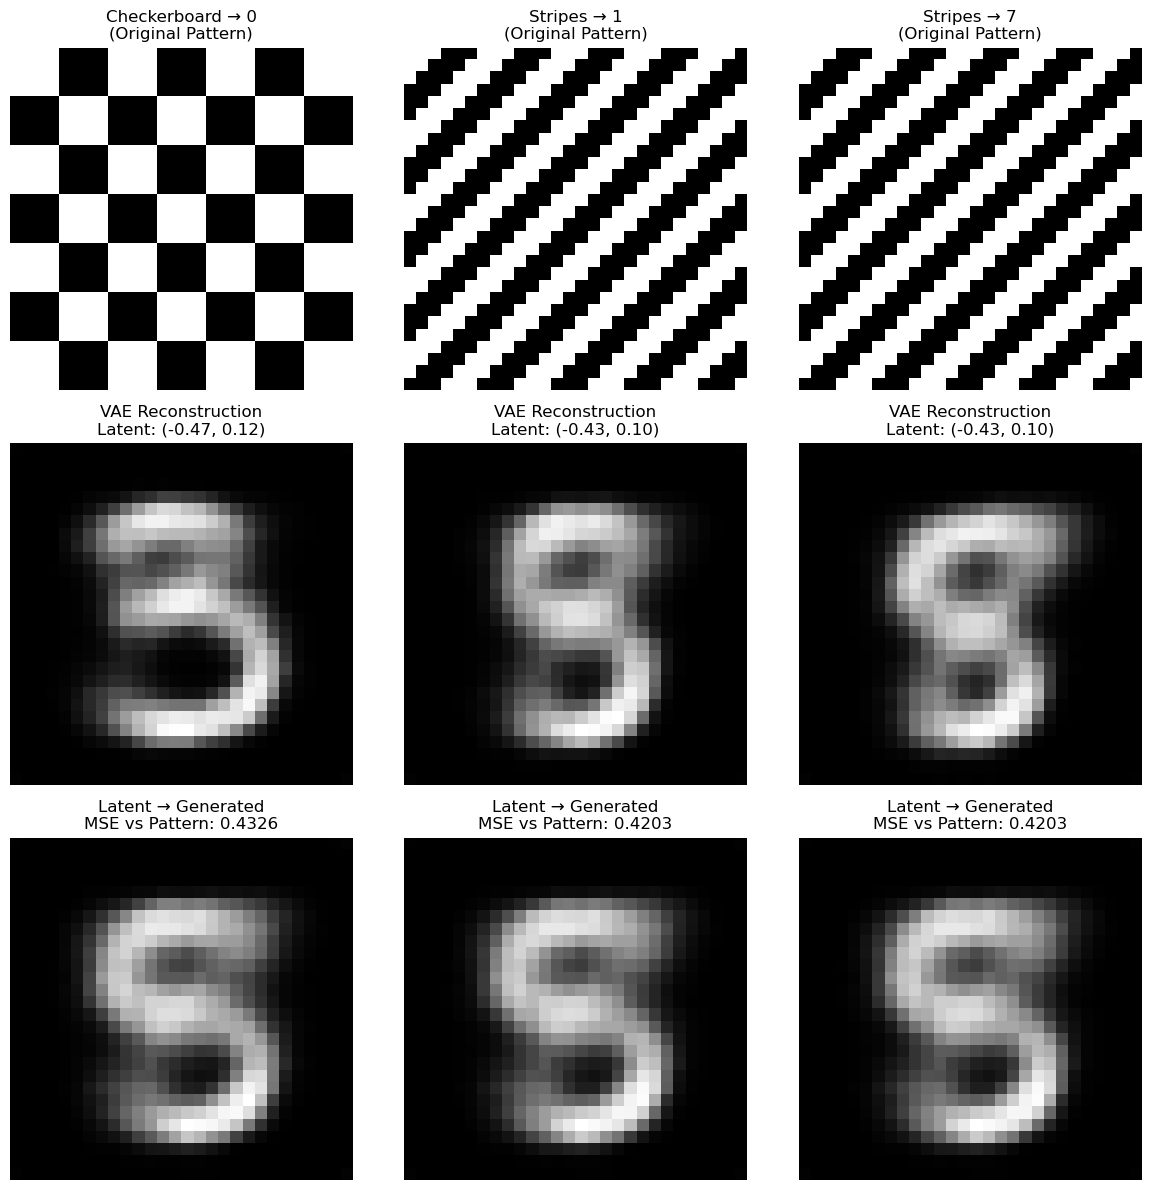

🔄 Demonstrating pattern morphing to digit 5...


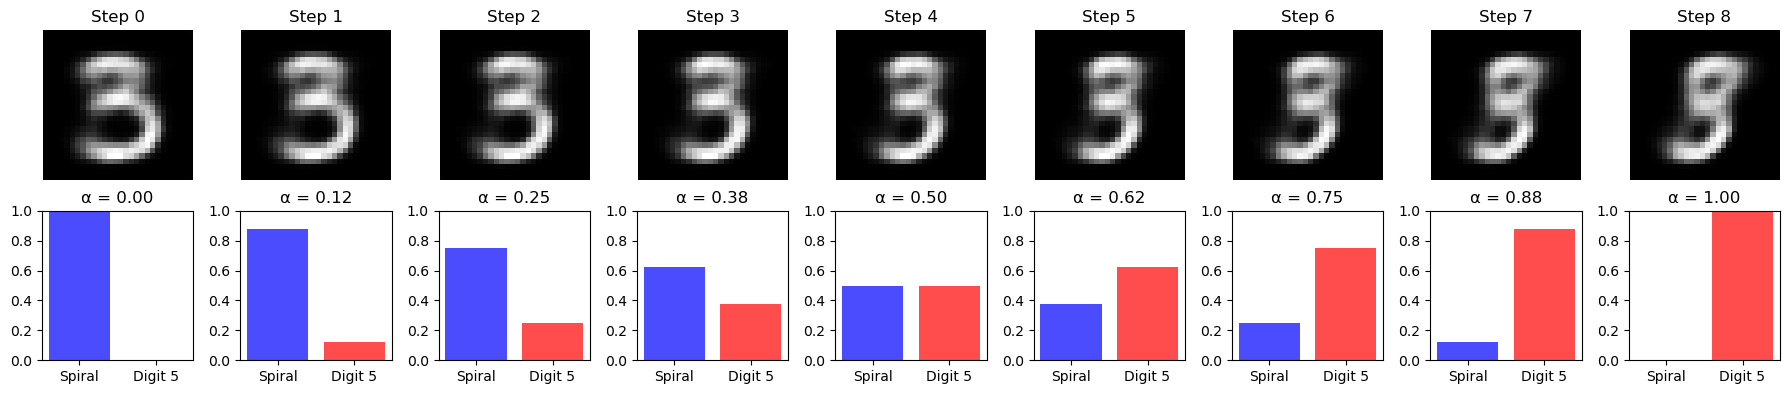

✅ Morphing demonstration complete!
   Original spiral latent: (-0.235, 0.332)
   Target digit 5 latent: (0.556, 0.077)


In [12]:
def create_extreme_non_digit_patterns(model, target_digits, device):
    """
    Create extremely non-digit-like patterns that still fool the VAE.
    These will be geometric patterns, textures, and abstract designs.
    """
    model.eval()
    extreme_patterns = []
    pattern_names = []
    
    print("🔷 Creating extreme non-digit patterns...")
    
    for digit in target_digits:
        print(f"\n🎯 Creating extreme pattern for digit {digit}...")
        
        # Create different types of patterns
        patterns = []
        names = []
        
        # Pattern 1: Checkerboard
        checkerboard = torch.zeros(1, 1, 28, 28, device=device)
        for i in range(28):
            for j in range(28):
                if (i // 4 + j // 4) % 2 == 0:
                    checkerboard[0, 0, i, j] = 1.0
        patterns.append(checkerboard)
        names.append(f"Checkerboard → {digit}")
        
        # Pattern 2: Diagonal stripes
        stripes = torch.zeros(1, 1, 28, 28, device=device)
        for i in range(28):
            for j in range(28):
                if (i + j) % 6 < 3:
                    stripes[0, 0, i, j] = 1.0
        patterns.append(stripes)
        names.append(f"Stripes → {digit}")
        
        # Pattern 3: Concentric circles
        circles = torch.zeros(1, 1, 28, 28, device=device)
        center_x, center_y = 14, 14
        for i in range(28):
            for j in range(28):
                dist = ((i - center_x)**2 + (j - center_y)**2)**0.5
                if int(dist) % 4 < 2:
                    circles[0, 0, i, j] = 1.0
        patterns.append(circles)
        names.append(f"Circles → {digit}")
        
        # Pattern 4: Random noise with structure
        noise = torch.rand(1, 1, 28, 28, device=device)
        # Apply a threshold to create binary noise
        noise = (noise > 0.5).float()
        patterns.append(noise)
        names.append(f"Noise → {digit}")
        
        # Test each pattern and find the one that works best
        best_pattern = None
        best_name = None
        best_score = float('inf')
        
        # Get target latent position for this digit
        target_latent = None
        with torch.no_grad():
            digit_latents = []
            for data, labels in test_loader:
                data = data.to(device)
                labels = labels.to(device)
                mu, _ = model.encoder(data)
                
                for i, label in enumerate(labels):
                    if label.item() == digit:
                        digit_latents.append(mu[i])
                        if len(digit_latents) >= 20:  # Get enough samples
                            break
                if len(digit_latents) >= 20:
                    break
            
            if digit_latents:
                target_latent = torch.stack(digit_latents).mean(dim=0).unsqueeze(0)
        
        if target_latent is None:
            print(f"   ⚠️ Could not find target latent for digit {digit}")
            continue
        
        # Test patterns
        with torch.no_grad():
            for pattern, name in zip(patterns, names):
                mu, _ = model.encoder(pattern)
                distance = F.mse_loss(mu, target_latent).item()
                
                if distance < best_score:
                    best_score = distance
                    best_pattern = pattern.clone()
                    best_name = name
        
        if best_pattern is not None:
            extreme_patterns.append(best_pattern)
            pattern_names.append(best_name)
            print(f"   ✅ Best pattern: {best_name.split(' → ')[0]} (distance: {best_score:.4f})")
    
    return extreme_patterns, pattern_names


def visualize_extreme_patterns(model, extreme_patterns, pattern_names, device):
    """Visualize extreme non-digit patterns and their VAE interpretations"""
    model.eval()
    
    n_patterns = len(extreme_patterns)
    fig, axes = plt.subplots(3, n_patterns, figsize=(4*n_patterns, 12))
    
    if n_patterns == 1:
        axes = axes.reshape(-1, 1)
    
    print("🔍 Analyzing extreme patterns...")
    
    with torch.no_grad():
        for i, (pattern, name) in enumerate(zip(extreme_patterns, pattern_names)):
            # Original pattern
            pattern_np = pattern.cpu().squeeze().numpy()
            axes[0, i].imshow(pattern_np, cmap='gray')
            axes[0, i].set_title(f'{name}\n(Original Pattern)')
            axes[0, i].axis('off')
            
            # VAE reconstruction
            recon, mu, logvar = model(pattern)
            recon_np = recon.cpu().squeeze().numpy()
            axes[1, i].imshow(recon_np, cmap='gray')
            axes[1, i].set_title(f'VAE Reconstruction\nLatent: ({mu[0,0]:.2f}, {mu[0,1]:.2f})')
            axes[1, i].axis('off')
            
            # What would the VAE generate at this latent position?
            generated = model.decoder(mu)
            generated_np = generated.cpu().squeeze().numpy()
            axes[2, i].imshow(generated_np, cmap='gray')
            axes[2, i].set_title(f'Latent → Generated\nMSE vs Pattern: {F.mse_loss(pattern, generated).item():.4f}')
            axes[2, i].axis('off')
            
            # Print analysis
            recon_error = F.mse_loss(pattern, recon).item()
            print(f"   {name}:")
            print(f"     Latent position: ({mu[0,0]:.3f}, {mu[0,1]:.3f})")
            print(f"     Reconstruction error: {recon_error:.6f}")
    
    plt.tight_layout()
    plt.show()


def demonstrate_pattern_morphing(model, device, digit=5):
    """
    Demonstrate morphing from a geometric pattern to a digit-like shape
    by optimizing in latent space
    """
    model.eval()
    print(f"🔄 Demonstrating pattern morphing to digit {digit}...")
    
    # Start with a geometric pattern (spiral)
    spiral = torch.zeros(1, 1, 28, 28, device=device)
    center_x, center_y = 14, 14
    for i in range(28):
        for j in range(28):
            x, y = i - center_x, j - center_y
            angle = np.arctan2(y, x)
            radius = (x**2 + y**2)**0.5
            
            # Create spiral pattern
            spiral_value = np.sin(3 * angle + 0.3 * radius)
            if spiral_value > 0.3:
                spiral[0, 0, i, j] = 1.0
    
    # Get target latent for the digit
    target_latent = None
    with torch.no_grad():
        digit_latents = []
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            mu, _ = model.encoder(data)
            
            for i, label in enumerate(labels):
                if label.item() == digit:
                    digit_latents.append(mu[i])
                    if len(digit_latents) >= 30:
                        break
            if len(digit_latents) >= 30:
                break
        
        if digit_latents:
            target_latent = torch.stack(digit_latents).mean(dim=0)
    
    if target_latent is None:
        print(f"Could not find samples for digit {digit}")
        return
    
    # Create interpolation in latent space
    with torch.no_grad():
        original_mu, _ = model.encoder(spiral)
        original_mu = original_mu.squeeze()
        
        # Create interpolation steps
        steps = 8
        interpolated_images = []
        
        for step in range(steps + 1):
            alpha = step / steps
            interpolated_latent = (1 - alpha) * original_mu + alpha * target_latent
            interpolated_img = model.decoder(interpolated_latent.unsqueeze(0))
            interpolated_images.append(interpolated_img)
    
    # Visualize morphing
    fig, axes = plt.subplots(2, steps + 1, figsize=(2*(steps+1), 4))
    
    for i, img in enumerate(interpolated_images):
        img_np = img.cpu().squeeze().numpy()
        
        # Top row: generated images
        axes[0, i].imshow(img_np, cmap='gray')
        axes[0, i].set_title(f'Step {i}')
        axes[0, i].axis('off')
        
        # Bottom row: show interpolation progress
        alpha = i / steps
        axes[1, i].bar(['Spiral', f'Digit {digit}'], [1-alpha, alpha], color=['blue', 'red'], alpha=0.7)
        axes[1, i].set_ylim(0, 1)
        axes[1, i].set_title(f'α = {alpha:.2f}')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Morphing demonstration complete!")
    print(f"   Original spiral latent: ({original_mu[0]:.3f}, {original_mu[1]:.3f})")
    print(f"   Target digit {digit} latent: ({target_latent[0]:.3f}, {target_latent[1]:.3f})")


# Generate extreme patterns
print("🎭 Creating extreme non-digit patterns that fool the VAE...")
extreme_patterns, pattern_names = create_extreme_non_digit_patterns(
    model, [0, 1, 7], device
)

# Visualize extreme patterns
if extreme_patterns:
    visualize_extreme_patterns(model, extreme_patterns, pattern_names, device)
    
    # Demonstrate pattern morphing
    demonstrate_pattern_morphing(model, device, digit=5)
else:
    print("No extreme patterns generated successfully.")